# DivPs analysis Chain B45 OVA data 50000 random subsmpl RANDOM freqs
## RANDOM freqs

TCRDivER analysis of the Murine dataset with Blosum 45 distance used as TCR distance metric with randomly assigned frequencies. 

**Instructions** 

Set path to working directory which should contain: 

* divP_tsv directory: containting all the diversities calculated at varying $q$ and $\lambda$s the TCRDivER algorithm outputs
* filtered directory: containing all the filetered TCR repertoires the TCRDivER algorithm outputs


In [80]:
from os import listdir
from os.path import isfile, join
import os
import re
import pandas as pd
from collections import defaultdict
from collections import OrderedDict
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import decomposition
from sklearn.metrics import accuracy_score

In [81]:
def plt_divP(divP_df, sample_name, time, treatment, wdir_path): 
    divP_df_long = pd.melt(divP_df, "q", var_name = "Lambda", value_name = "DqZ")
    qs_label = [q if q != "7" else "$\infty$" for q in list(map(str, divP_df["q"]))]
    sns.color_palette("colorblind")
    plt.figure(figsize=(6,8))
    ax =sns.lineplot(x="q", y="DqZ", data=divP_df_long, hue = "Lambda", markers=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.fill_between(divP_df["q"].values, divP_df["16.0"].values, divP_df["identity"].values, 
                 facecolor='red', alpha = 0.2)
    
    plt.xticks(ticks = divP_df["q"].values, labels = qs_label, fontsize = 13)
    plt.yticks(ticks = range(0,13), fontsize = 13)
    plt.ylim(top=12)
    plt.xlabel("q", fontsize = 20)
    plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
    plt.title(sample_name, fontsize = 20)
    if not os.path.isdir(wdir_path+"divPs/"):
        os.makedirs(wdir_path+"divPs/", exist_ok=False)
    plt.savefig(wdir_path + "divPs/"+ sample_name + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
    return plt

In [82]:
def calculate_area_between_curves(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas.reverse()
    area_dict = OrderedDict()
    for index,first in list(enumerate(lambdas)):
        for second in lambdas[index+1:]:
            area = np.trapz(divP_df[first].values , x=divP_df["q"].values) - np.trapz(divP_df[second].values , x=divP_df["q"].values)
            area_dict["_".join([first, second, "area"])] = area
    return area_dict



In [83]:
def calculate_slopes(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas = [lb for lb in lambdas if lb != "0.0"]
    lambdas.reverse()
    slope_dict = OrderedDict()
    for lb in lambdas: 
        slope_dict["_".join(["0_1_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[1, lb]
        slope_dict["_".join(["0_2_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[2, lb]
        slope_dict["_".join(["1_2_slope", lb])] = divP_df.loc[1, lb]-divP_df.loc[2, lb]
    return slope_dict

In [84]:
def calculate_avg_delta_lambda_05_00(divP_df):
    avg_delta_lambda = divP_df[["0.0","0.1","0.2", "0.3", "0.4", "0.5"]].diff(axis = 1).mean().mean()
    return avg_delta_lambda

In [85]:
def make_divP_one_row_df(divP_df):
    divP_df_wo_L0 = divP_df.drop("0.0", axis = 1)
    list_of_lambdas = [lmbd for lmbd in list(divP_df_wo_L0) if lmbd != "q"]
    list_of_dqz = list()
    for lmbd in list_of_lambdas:
        for qu in divP_df_wo_L0["q"]:
            if qu == 7: 
                qu = 11
                qu_name = "infinity"
            qu_name = str(qu)
            list_of_dqz.append(("L_"+ lmbd + "_q_" +qu_name, divP_df_wo_L0.loc[qu,lmbd]))
    sample_dqz = pd.DataFrame(list_of_dqz).T
    sample_dqz.columns = sample_dqz.iloc[0]
    sample_dqz = sample_dqz.drop(sample_dqz.index[0])
    sample_dqz = sample_dqz.reset_index(drop = "True")
    return sample_dqz



In [86]:
# Set path to working directory:
wdir_path = "/Users/milvu/Documents/OneDrive - Danmarks Tekniske Universitet/TCR_analysis/TCRDivER_algorithm/datasets_divP_calculated/Chain_OVAexpt_data_B45_50000_random_subsmpl/OVAData1_random_freqs/"
#set path to metadata excel file
path_to_metadata ="../metadata/Cinelli_et_al_NF_MouseData_OVA_data_1.csv"


Let's make the metadata dataframe from the filenames themselves by establishing some criteria. 

# OVA data 1

In [87]:
# Read in metadata: 
mddf = pd.read_csv(wdir_path+ path_to_metadata, sep = ",")
mddf = mddf[["OVA data 1", "library", "in-vivo treatment", "post-immunisation time", "sample type"]]
mddf.columns = ["sample_name", "library", "treatment", "post_imm_time", "sample_type"]
mddf.loc[(mddf.post_imm_time == 'm2'),'post_imm_time']='d60'
mddf.sort_values(by=["post_imm_time", "treatment"], inplace=True)
mddf = mddf.reset_index(drop = True)

In [88]:
#read in filtered filenames and count unique CDR3s
filtered_fpath = wdir_path + "filtered/"
files = [f for f in listdir(filtered_fpath) if isfile(join(filtered_fpath, f))]
files = [f for f in listdir(filtered_fpath) if f.endswith(".tsv")]
unique_CDR3s_dict = defaultdict()
column_names = ["sample_name", "age", "immunisation", "unique_CDR3s"]
for file in files: 
    num_lines = sum(1 for line in open(filtered_fpath+file))
    unique_CDR3s_dict["_".join(file.split("_")[:-1])]=num_lines

files

['SB2_GTC_clean_cdr3_filtered.tsv',
 'SB2_CCG_clean_cdr3_filtered.tsv',
 'SB2_ATT_clean_cdr3_filtered.tsv',
 'SB1_CAC_clean_cdr3_filtered.tsv',
 'SB2_ACC_clean_cdr3_filtered.tsv',
 'SB1_TAT_clean_cdr3_filtered.tsv',
 'EAE1B_CCG_clean_cdr3_filtered.tsv',
 'EAE1B_TTG_clean_cdr3_filtered.tsv',
 'SB1_TGC_clean_cdr3_filtered.tsv',
 'SB2_GCT_clean_cdr3_filtered.tsv',
 'SB1_GCT_clean_cdr3_filtered.tsv',
 'SB1_GAG_clean_cdr3_filtered.tsv',
 'EAE1A_TTG_clean_cdr3_filtered.tsv',
 'SB1_AGG_clean_cdr3_filtered.tsv',
 'SB1_CTA_clean_cdr3_filtered.tsv',
 'SB1_AAA_clean_cdr3_filtered.tsv',
 'SB1_TCA_clean_cdr3_filtered.tsv',
 'CPX1A_GGA_clean_cdr3_filtered.tsv',
 'SB1_ACC_clean_cdr3_filtered.tsv',
 'CPX1A_TTG_clean_cdr3_filtered.tsv',
 'CPX1B_CAC_clean_cdr3_filtered.tsv',
 'SB1_ATT_clean_cdr3_filtered.tsv',
 'SB1_CCG_clean_cdr3_filtered.tsv',
 'SB2_CAC_clean_cdr3_filtered.tsv',
 'SB1_TTG_clean_cdr3_filtered.tsv',
 'SB1_GTC_clean_cdr3_filtered.tsv',
 'SB2_CGT_clean_cdr3_filtered.tsv',
 'EAE1A_GGA_clea

In [89]:
unique_CDR3_list = [unique_CDR3s_dict["".join([row["sample_name"], "_clean_cdr3"])] for index, row in mddf.iterrows()]
mddf["unique_CDR3s"] = unique_CDR3_list
mddf

sample_name library  treatment post_imm_time sample_type  unique_CDR3s
0    CPX1A_GGA     CPX  untreated            d0      spleen         32295
1    CPX1A_TTG     CPX  untreated            d0      spleen         30541
2    CPX1B_CAC     CPX  untreated            d0      spleen         30131
3    EAE1A_GGA     EAE  untreated            d0      spleen         28170
4    EAE1A_TTG     EAE  untreated            d0      spleen         28699
5    EAE1B_CCG     EAE  untreated            d0      spleen         14866
6    EAE1B_TTG     EAE  untreated            d0      spleen         21506
7      SB1_TGC     SB1  untreated            d0      spleen         21727
8      SB1_ACC     SB1        CFA           d14      spleen         27156
9      SB1_CTA     SB1        CFA           d14      spleen         25445
10     SB1_GCT     SB1        CFA           d14      spleen         25435
11     SB1_AGG     SB1        OVA           d14      spleen         33190
12     SB1_GAG     SB1        OVA           d14      spleen         27132
13     SB1_TAT     SB1        OVA           d14      spleen         32121
14     SB1_AAA     SB1        CFA            d5      spleen         30400
15     SB1_CCG     SB1        CFA            d5      spleen         29493
16     SB1_TTG     SB1        CFA            d5      spleen         32263
17     SB1_ATT     SB1        OVA            d5      spleen         31315
18     SB1_CAC     SB1        OVA            d5      spleen         30520
19     SB1_GTC     SB1        OVA            d5      spleen         32077
20     SB2_ATT     SB2        CFA           d60      spleen         19626
21     SB2_CCG     SB2        CFA           d60      spleen         23146
22     SB2_CGT     SB2        CFA           d60      spleen         15539
23     SB2_CAC     SB2        OVA           d60      spleen         16251
24     SB2_GCT     SB2        OVA           d60      spleen         20608
25     SB2_GTC     SB2        OVA           d60      spleen         17966

## Plot Diversity Profiles for individual samples 

In [90]:
# load filenames: 
divP_fpath = wdir_path + "divP_tsv/"
divP_files = [f for f in listdir(divP_fpath) if isfile(join(divP_fpath, f))]
divP_files = [f for f in divP_files if f.endswith('tsv')]
divP_files = [re.sub('\.tsv$', '', f) for f in divP_files]
divP_files.sort()
divP_files = [f for f in divP_files]

divP_files

['CPX1A_GGA_clean_cdr3_divP',
 'CPX1A_TTG_clean_cdr3_divP',
 'CPX1B_CAC_clean_cdr3_divP',
 'EAE1A_GGA_clean_cdr3_divP',
 'EAE1A_TTG_clean_cdr3_divP',
 'EAE1B_CCG_clean_cdr3_divP',
 'EAE1B_TTG_clean_cdr3_divP',
 'SB1_AAA_clean_cdr3_divP',
 'SB1_ACC_clean_cdr3_divP',
 'SB1_AGG_clean_cdr3_divP',
 'SB1_ATT_clean_cdr3_divP',
 'SB1_CAC_clean_cdr3_divP',
 'SB1_CCG_clean_cdr3_divP',
 'SB1_CTA_clean_cdr3_divP',
 'SB1_GAG_clean_cdr3_divP',
 'SB1_GCT_clean_cdr3_divP',
 'SB1_GTC_clean_cdr3_divP',
 'SB1_TAT_clean_cdr3_divP',
 'SB1_TGC_clean_cdr3_divP',
 'SB1_TTG_clean_cdr3_divP',
 'SB2_ATT_clean_cdr3_divP',
 'SB2_CAC_clean_cdr3_divP',
 'SB2_CCG_clean_cdr3_divP',
 'SB2_CGT_clean_cdr3_divP',
 'SB2_GCT_clean_cdr3_divP',
 'SB2_GTC_clean_cdr3_divP']

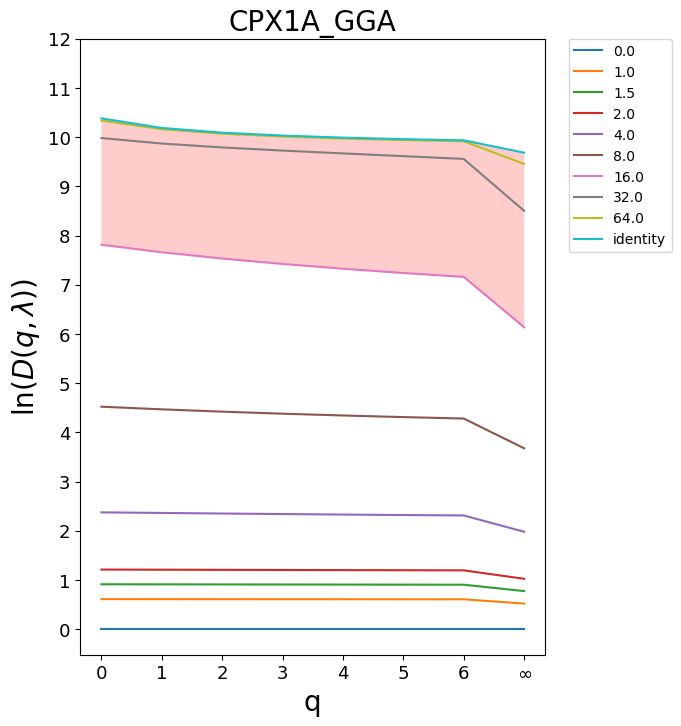

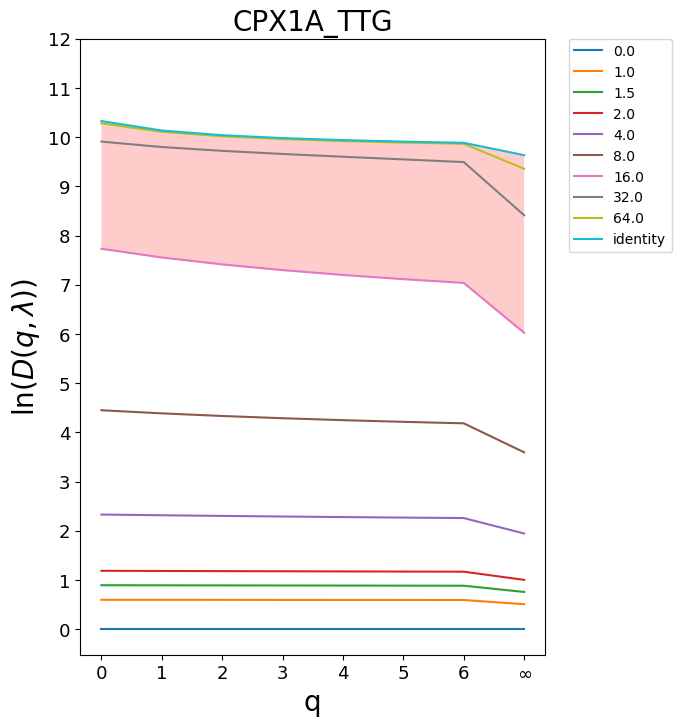

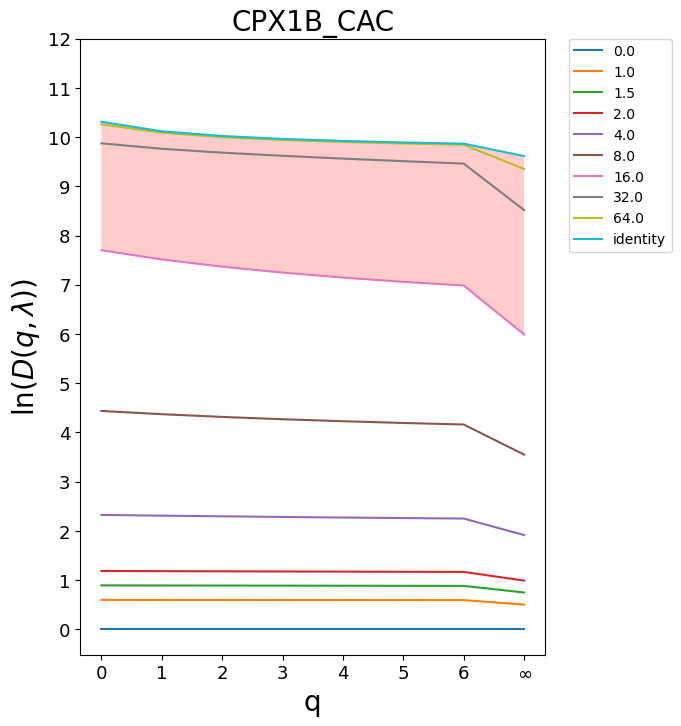

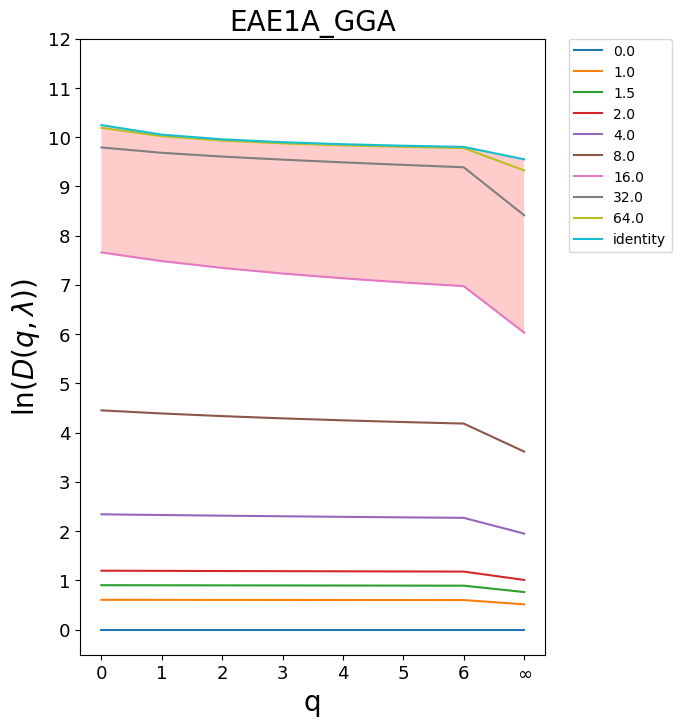

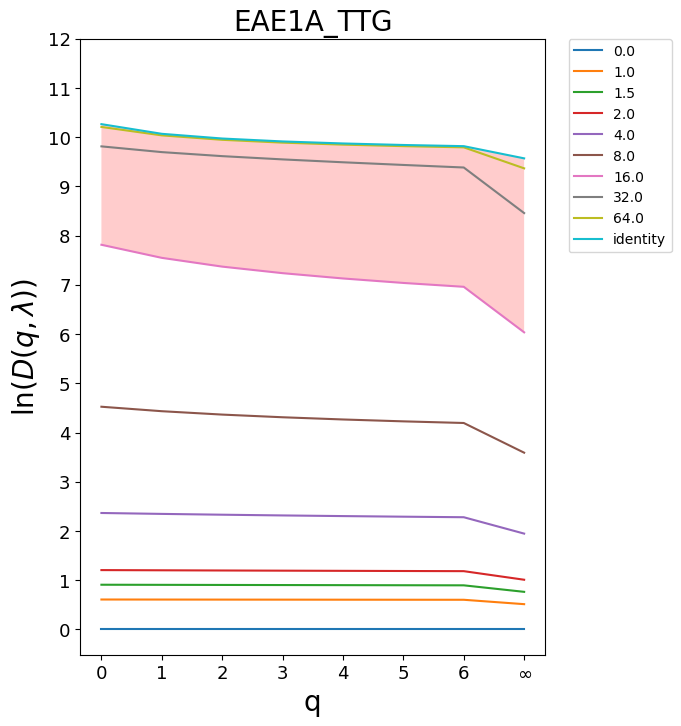

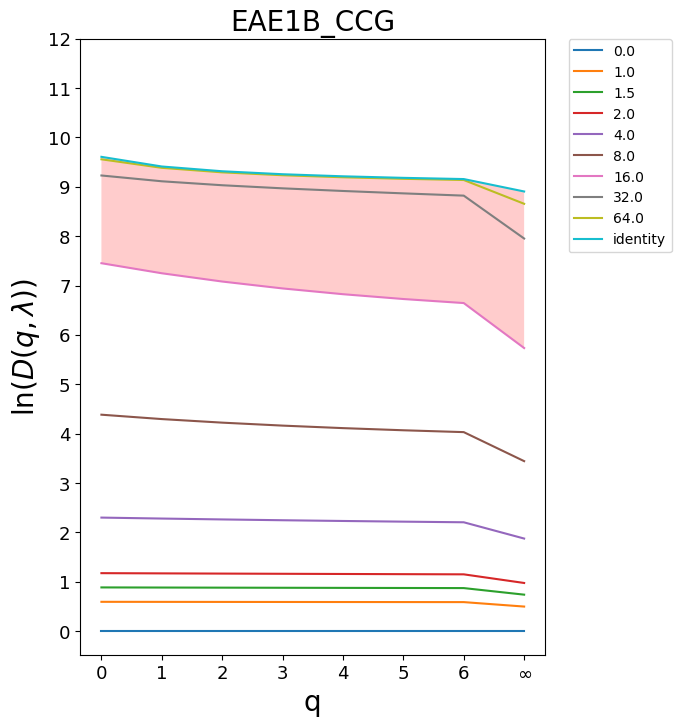

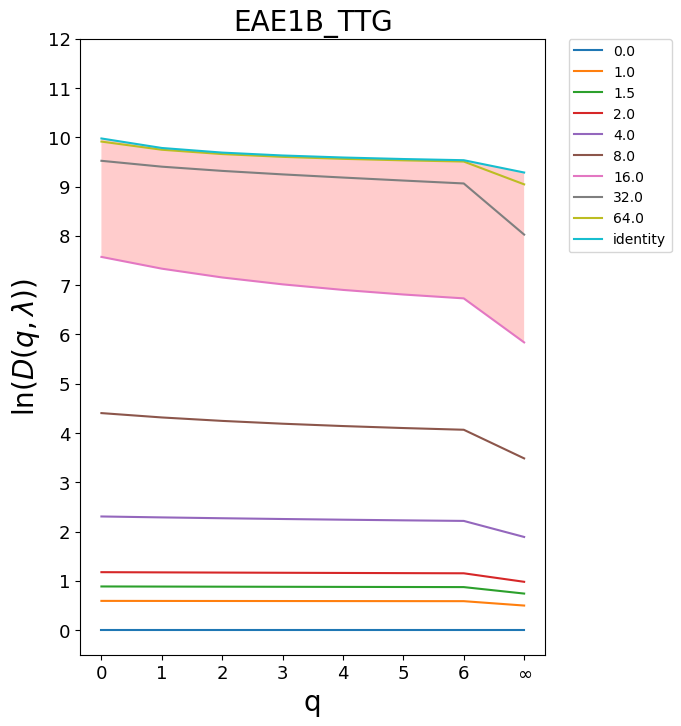

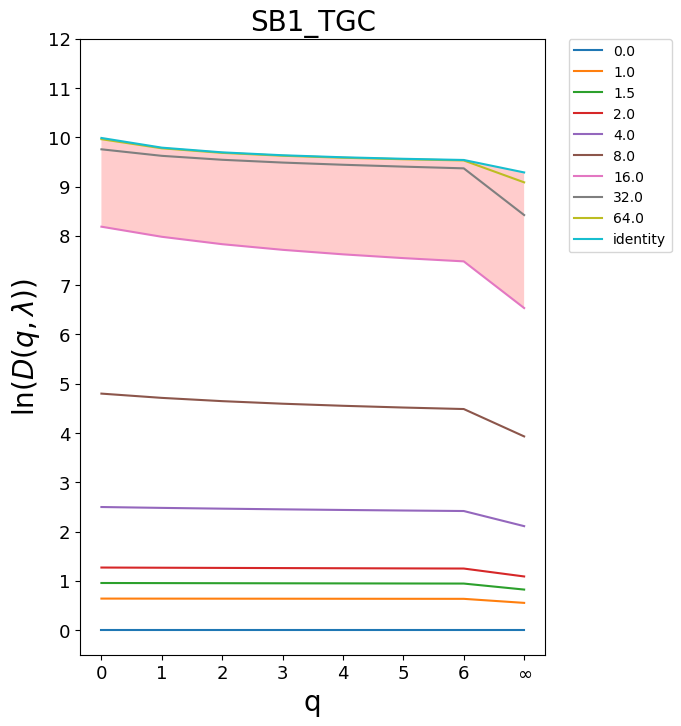

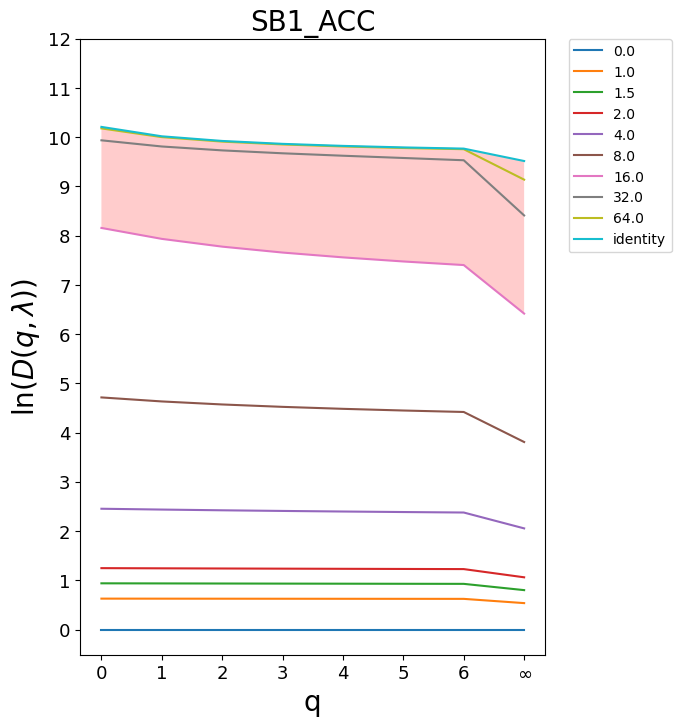

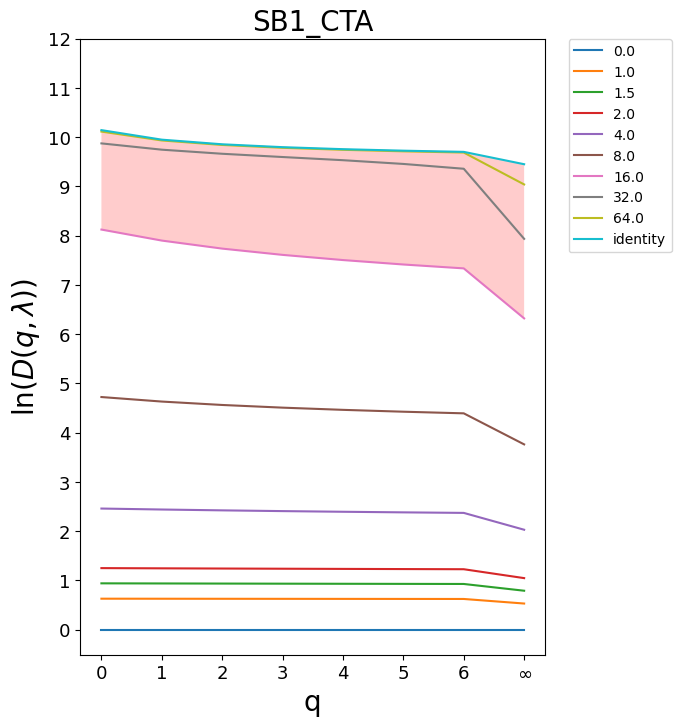

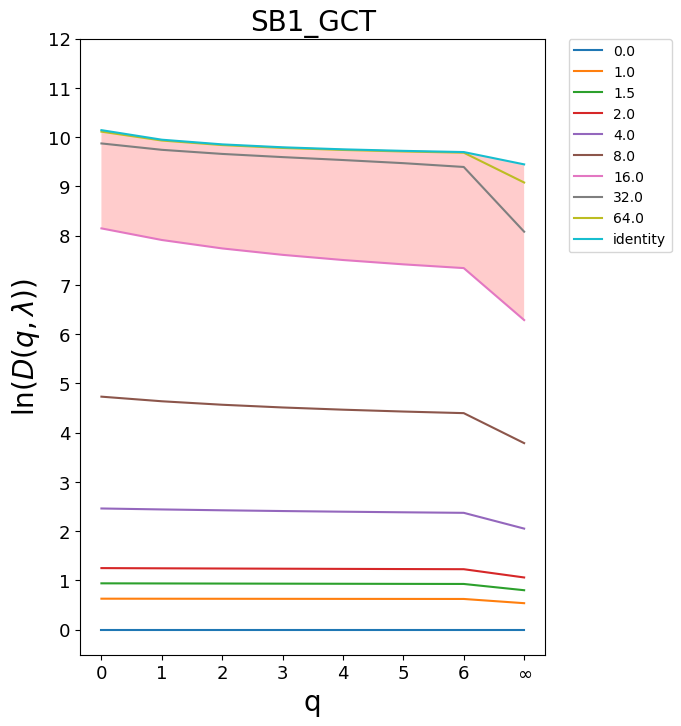

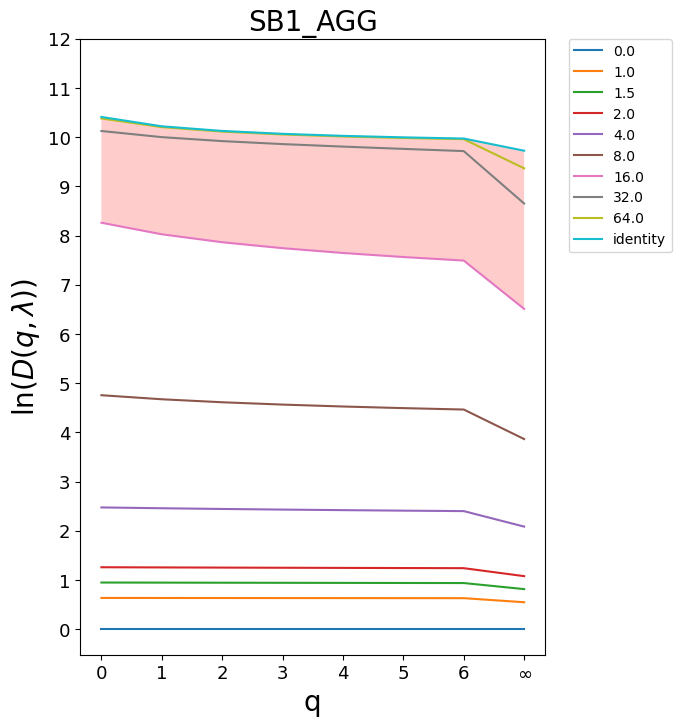

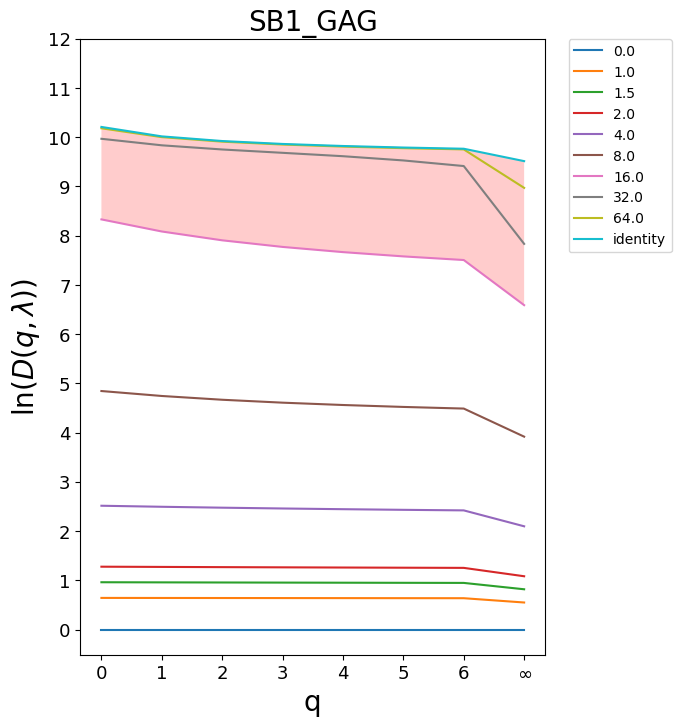

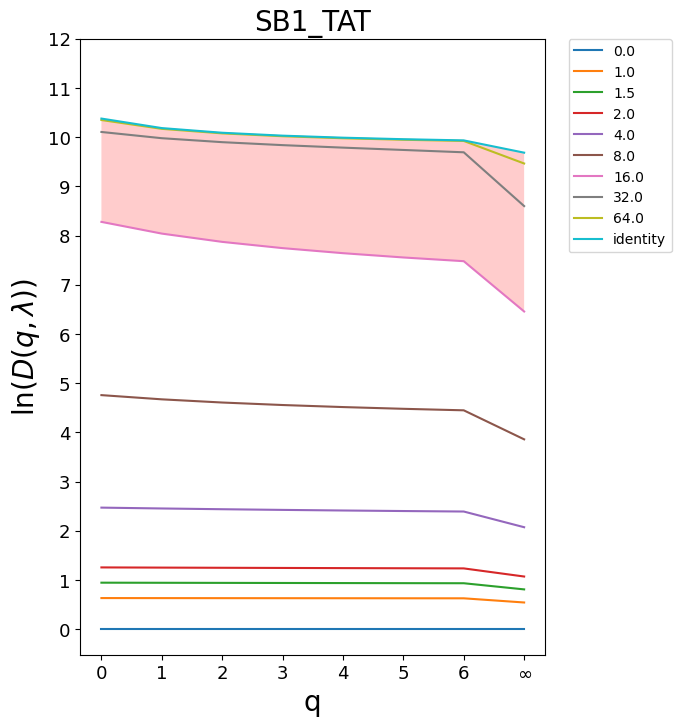

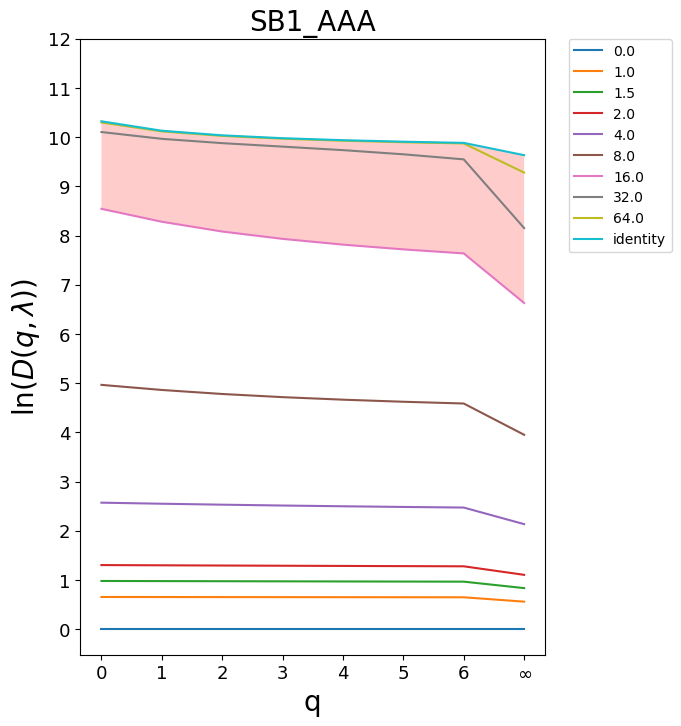

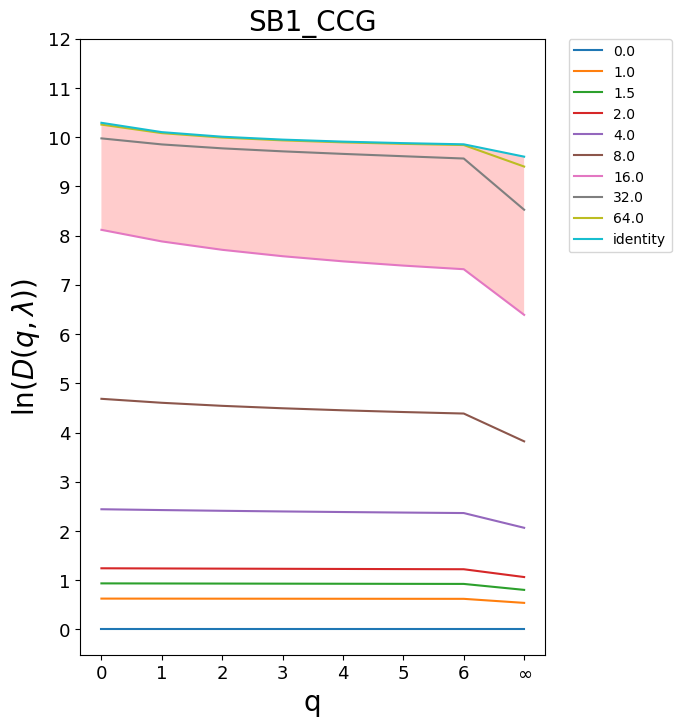

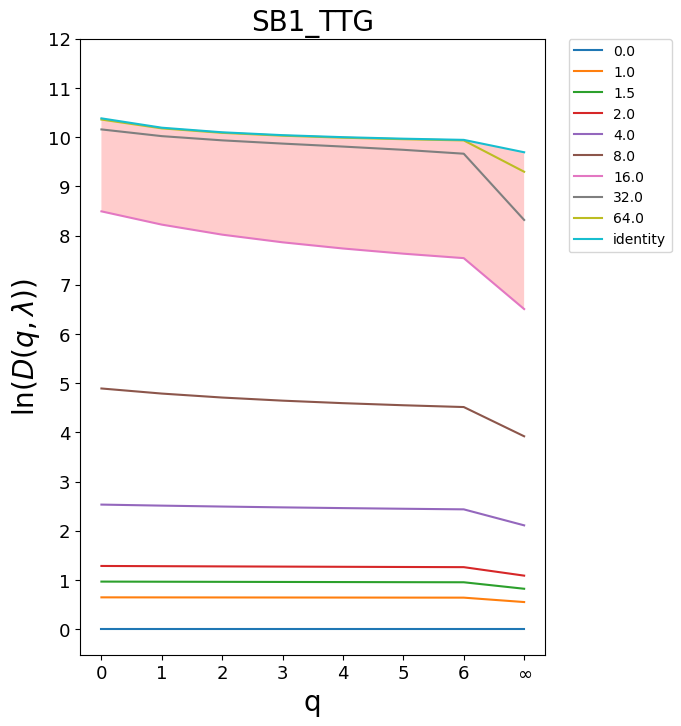

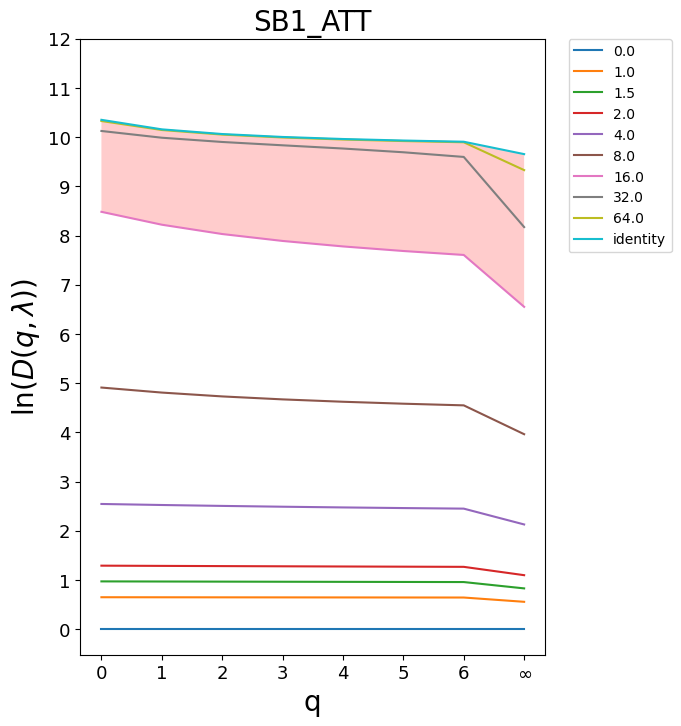

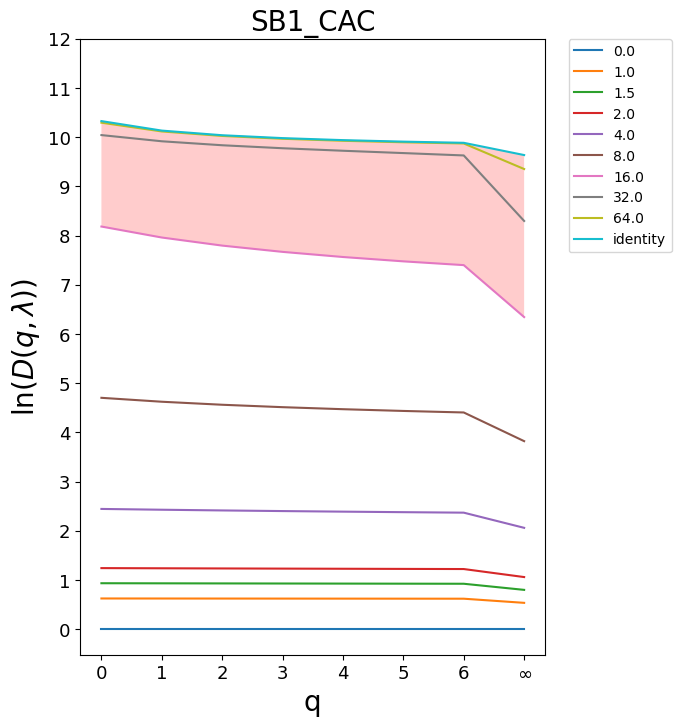

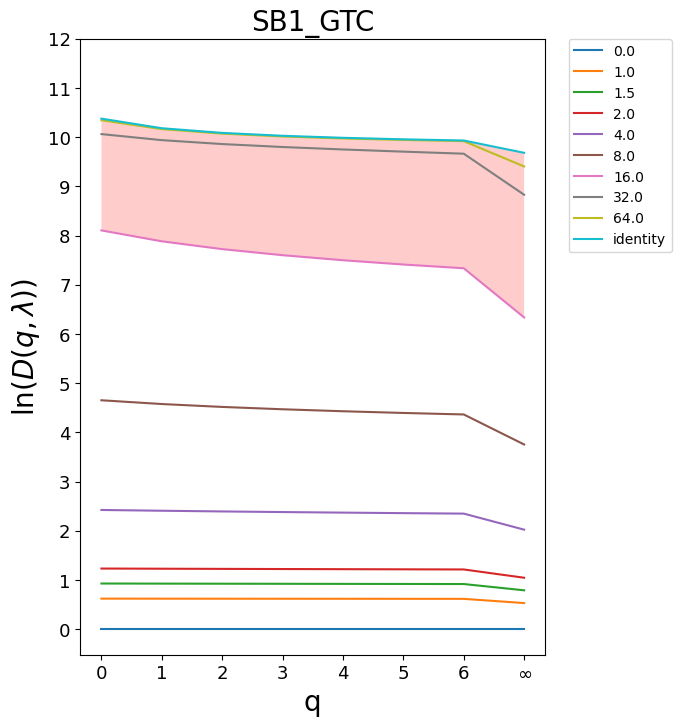

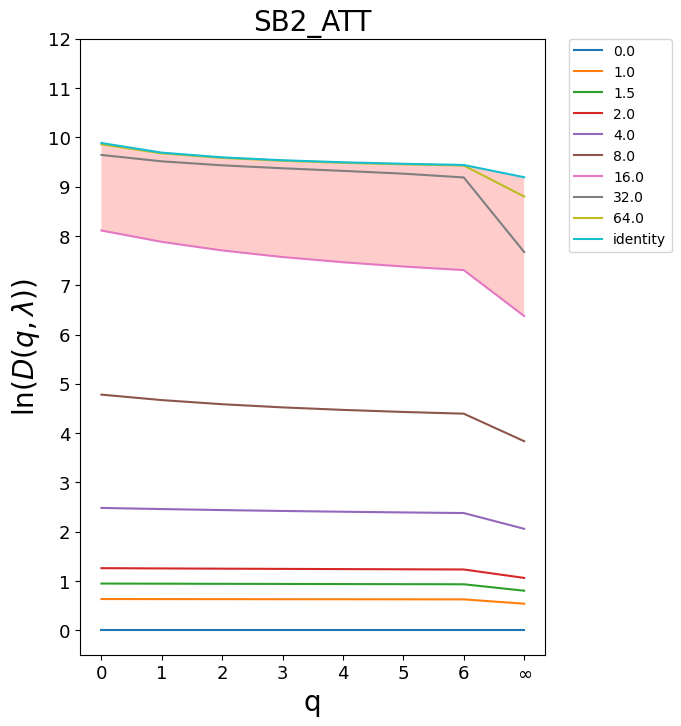

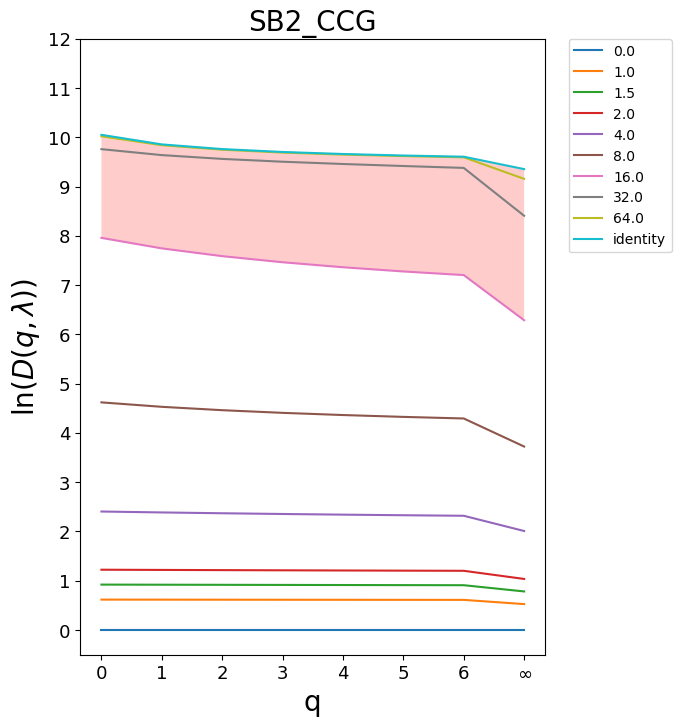

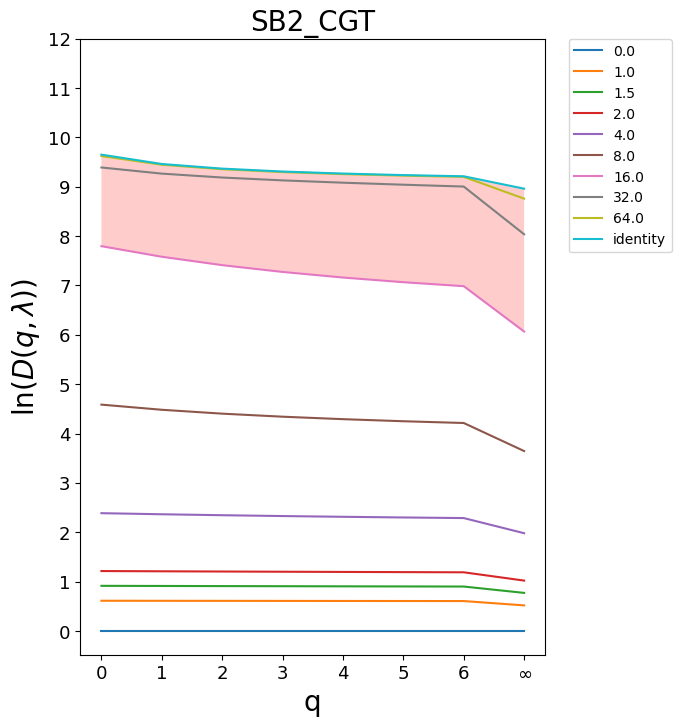

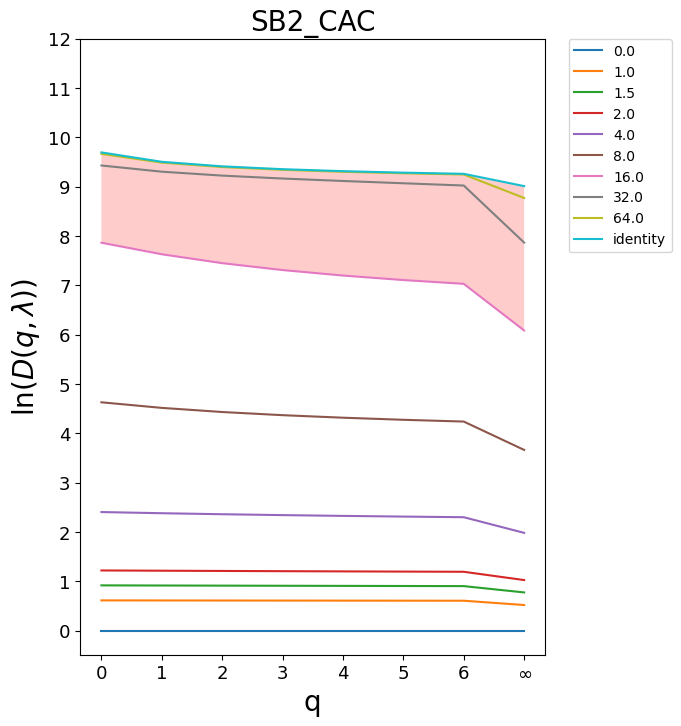

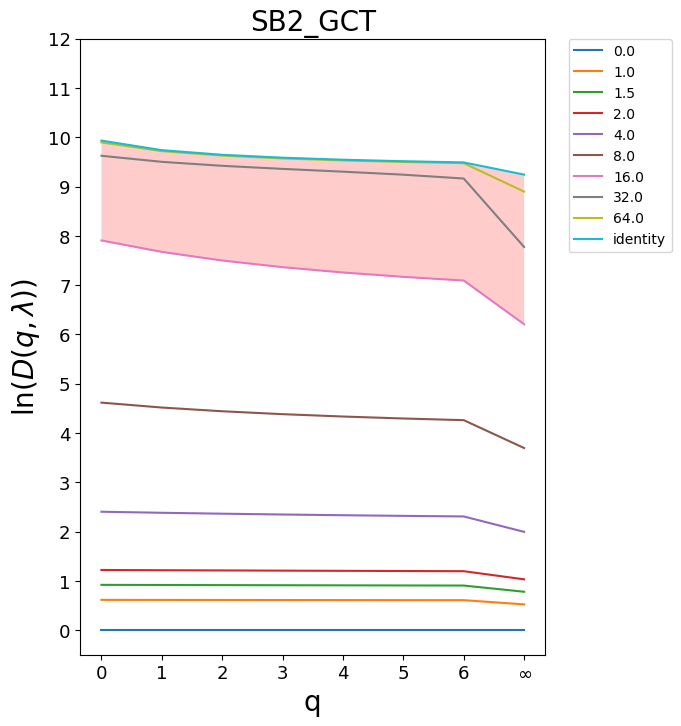

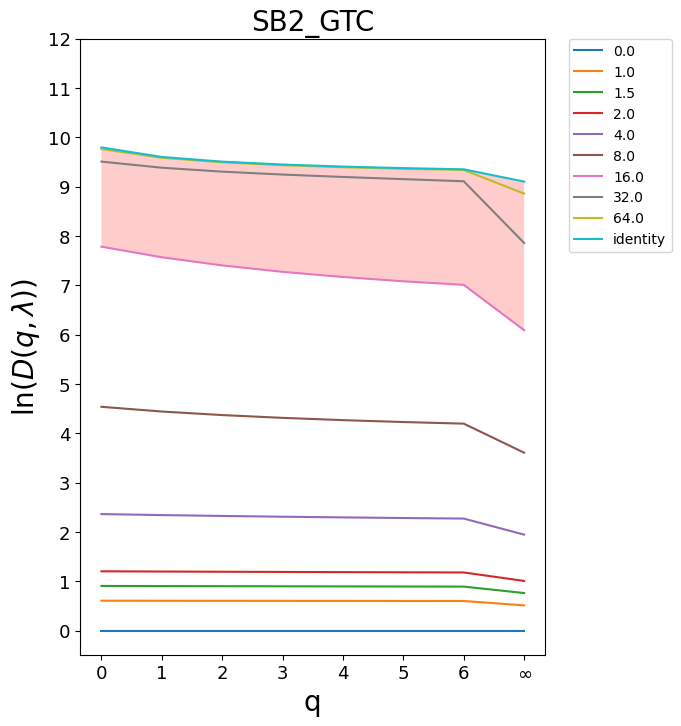

In [91]:
# define divP files 
divP_fpath = wdir_path + "divP_tsv/"
# Initiate empty list to store area dictionaries 
divP_areas = []
divP_slopes = []
average_delta_lambda = []
divP1_all_list = []
# iterate trough files 
for index,row in mddf.iterrows():
    # create pandas dataframes of divPs
    sample_name = row['sample_name'] 
    treatment = row['treatment']
    time = row['post_imm_time']
    divP_df = pd.read_csv(divP_fpath + row['sample_name'] + "_clean_cdr3_divP.tsv", comment='#', sep = '\t')
    divP_df = divP_df.set_index('q')
    divP_df.insert(0, '0.0', [1]*divP_df.shape[0])
    #ln transform the dataframe
    divP_df = np.log(divP_df)
    qs = divP_df.index.values[:-1]
    qs = np.append(qs, (divP_df.index.values[-2] + 1))
    divP_df["q"] = qs
    #calculate areas dictionary and append to a list
    divP_areas.append(calculate_area_between_curves(divP_df))
    #calculate slopes dictionary and append to a list
    divP_slopes.append(calculate_slopes(divP_df))
    ##calculate average delta lambda for small lambda: 
    average_delta_lambda.append(calculate_avg_delta_lambda_05_00(divP_df))
    #convert divP into a row df and append to a list: 
    divP1_all_list.append(make_divP_one_row_df(divP_df))
    #plot divPs
    divP_df = divP_df.drop(["0.1", "0.2", "0.25", "0.3", "0.4", "0.5", "0.75"], axis =1 )
    plt_divP(divP_df, sample_name, time, treatment, wdir_path)
    
divP_areas_df = pd.DataFrame.from_dict(divP_areas)
divP_slopes_df = pd.DataFrame.from_dict(divP_slopes)
average_delta_lambda_df = pd.DataFrame(average_delta_lambda, columns = ["Average area for small lambdas"])
divP1_all_df = pd.concat(divP1_all_list)
divP1_all_df = divP1_all_df.reset_index(drop = "True")
divP1_all_df = pd.concat([divP1_all_df, mddf], axis = 1)

divP_features = pd.concat([divP_areas_df, 
                           divP_slopes_df,
                           average_delta_lambda_df, 
                           mddf], axis=1)

In [92]:
divP_features = divP_features.rename(columns={"treatment": "Treatment", "post_imm_time": "Post-immunisation Time"})

In [93]:
divP_features["Post-immunisation Time"] = divP_features['Post-immunisation Time'].str.replace('d', '')
divP_features["Post-immunisation Time"] = divP_features["Post-immunisation Time"].astype(str).astype(int)
divP_features = divP_features.sort_values('Post-immunisation Time')
divP_features = divP_features.reset_index(drop = True)
divP_features





identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.260631            2.756932           18.913259   
1             0.288580            2.885291           19.373238   
2             0.294345            2.950367           19.586562   
3             0.293246            3.042477           19.233970   
4             0.283910            3.097450           19.192278   
5             0.277341            2.481461           16.730903   
6             0.326039            3.305567           18.761478   
7             0.174812            1.492959           13.909759   
8             0.242772            2.035855           17.525364   
9             0.242912            2.143065           16.736413   
10            0.242428            2.096440           15.298332   
11            0.278679            2.005517           15.769930   
12            0.215468            2.225527           17.039012   
13            0.258617            2.136906           14.796379   
14            0.364003            2.314711           15.067606   
15            0.278142            2.023394           16.758885   
16            0.281940            2.187346           15.819228   
17            0.302964            2.324330           15.857470   
18            0.282334            1.930260           15.958669   
19            0.199149            1.931574           16.517524   
20            0.289961            2.418929           15.992247   
21            0.279932            2.008576           14.201323   
22            0.191251            1.876657           16.156225   
23            0.188761            1.736011           14.751261   
24            0.218301            1.934085           14.781503   
25            0.220617            2.066994           15.703396   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0           39.924540          54.035712          61.896686   
1           40.184230          54.007147          61.705502   
2           40.223322          53.962402          61.622793   
3           39.603541          53.376762          61.090749   
4           39.550286          53.378893          61.139037   
5           35.990586          49.269930          56.768277   
6           38.416650          51.821665          59.365238   
7           35.582325          50.473325          58.730297   
8           39.243736          53.716507          61.729939   
9           38.588524          53.224953          61.322685   
10          37.623734          52.780968          61.168575   
11          38.074175          53.136208          61.472763   
12          38.510385          53.048877          61.122315   
13          37.154123          52.438478          60.906481   
14          37.065970          52.006030          60.284117   
15          38.838321          53.641213          61.829386   
16          37.296518          51.882722          59.990414   
17          37.355165          51.920496          60.016630   
18          37.710753          52.366612          60.482655   
19          38.632226          53.422562          61.592077   
20          36.717092          50.854406          58.738682   
21          35.369087          49.983247          58.120936   
22          37.366893          51.612680          59.528351   
23          35.070322          49.045856          56.860609   
24          35.184977          49.260125          57.126763   
25          36.260480          50.170838          57.918826   

    identity_1.5_area  identity_1.0_area  identity_0.75_area  \
0           63.937375          66.006408           67.051254   
1           63.704972          65.732856           66.757205   
2           63.613711          65.633445           66.653865   
3           63.097676          65.134199           66.163266   
4           63.159935          65.211535           66.248578   
5           58.726139          60.715794           61.722284   
6           61.332559          63.330989           64.341623   
7      

In [94]:
divP1_all_df = divP1_all_df.rename(columns={"treatment": "Treatment", "post_imm_time": "Post-immunisation Time"})
divP1_all_df["Post-immunisation Time"] = divP1_all_df['Post-immunisation Time'].str.replace('d', '')
divP1_all_df["Post-immunisation Time"] = divP1_all_df["Post-immunisation Time"].astype(str).astype(int)
divP1_all_df = divP1_all_df.sort_values('Post-immunisation Time')
divP1_all_df = divP1_all_df.reset_index(drop = True)
divP1_all_df


L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.061603  0.061597   0.06159  0.061584  0.061577  0.061571  0.061564   
1   0.060447  0.060439  0.060432  0.060424  0.060417   0.06041  0.060402   
2   0.060274  0.060266  0.060259  0.060251  0.060244  0.060236  0.060228   
3   0.060767   0.06076  0.060753  0.060745  0.060738  0.060731  0.060723   
4   0.061303  0.061293  0.061284  0.061275  0.061266  0.061257  0.061248   
5   0.059625  0.059615  0.059605  0.059595  0.059585  0.059575  0.059565   
6   0.059823  0.059814  0.059804  0.059794  0.059785  0.059775  0.059766   
7   0.064398   0.06439  0.064381  0.064373  0.064364  0.064356  0.064347   
8   0.062555  0.062547  0.062539  0.062531  0.062523  0.062516  0.062508   
9    0.06308  0.063073  0.063065  0.063057  0.063049  0.063041  0.063033   
10  0.065461  0.065451   0.06544   0.06543   0.06542   0.06541    0.0654   
11  0.065079  0.065069  0.065059  0.065048  0.065038  0.065028  0.065018   
12  0.062987  0.062978   0.06297  0.062962  0.062954  0.062946  0.062938   
13  0.066094  0.066084  0.066073  0.066063  0.066053  0.066042  0.066032   
14  0.064739  0.064729  0.064719  0.064709  0.064698  0.064688  0.064678   
15  0.063793  0.063785  0.063777  0.063769  0.063761  0.063753  0.063745   
16  0.063477  0.063467  0.063458  0.063448  0.063439  0.063429   0.06342   
17  0.063479  0.063469  0.063459   0.06345   0.06344   0.06343  0.063421   
18  0.063305  0.063297  0.063289  0.063281  0.063272  0.063264  0.063256   
19   0.06366  0.063652  0.063643  0.063635  0.063627  0.063618   0.06361   
20  0.062027  0.062017  0.062006  0.061996  0.061985  0.061975  0.061964   
21  0.063936  0.063925  0.063914  0.063902  0.063891   0.06388  0.063869   
22  0.062052  0.062043  0.062034  0.062024  0.062015  0.062006  0.061997   
23  0.061544  0.061534  0.061523  0.061512  0.061501  0.061491   0.06148   
24  0.062041  0.062029  0.062018  0.062006  0.061995  0.061984  0.061972   
25  0.060982  0.060972  0.060962  0.060952  0.060942  0.060932  0.060922   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_4 L_identity_q_5  \
0    0.052662  0.123102  0.123076  ...       9.990092       9.959071   
1    0.051631  0.120792  0.120762  ...       9.939987       9.909144   
2    0.050983  0.120446  0.120415  ...       9.923338       9.892347   
3    0.051815  0.121429  0.121399  ...       9.857314         9.8267   
4    0.052154  0.122503  0.122466  ...       9.872327       9.841569   
5    0.050307  0.119146  0.119106  ...       9.212529       9.181224   
6    0.050638  0.119543  0.119505  ...       9.589834       9.559092   
7    0.055997  0.128704   0.12867  ...       9.594347       9.563634   
8     0.05381  0.125016  0.124984  ...       9.986356       9.955662   
9     0.05439  0.126069  0.126037  ...       9.939561       9.908988   
10   0.056469  0.130835  0.130794  ...       9.962255        9.93119   
11   0.055808  0.130072  0.130031  ...        9.99919       9.968436   
12   0.054478  0.125881  0.125848  ...       9.909432       9.878795   
13   0.056947  0.132105  0.132062  ...       9.938185        9.90772   
14   0.055773  0.129389  0.129348  ...       9.821393       9.790193   
15   0.055293  0.127493   0.12746  ...      10.026067       9.995439   
16   0.054632  0.126862  0.126824  ...        9.75431       9.723325   
17   0.053939  0.126864  0.126825  ...       9.757417        9.72682   
18   0.054369  0.126518  0.126485  ...       9.823583       9.792591   
19   0.054869   0.12723  0.127196  ...       9.988808       9.957987   
20   0.053211  0.123963   0.12392  ...       9.545549       9.514744   
21   0.054789  0.127784  0.127738  ...       9.494009       9.463272   
22   0.053122  0.124011  0.123973  ...       9.660227       9.629411   
23   0.052377  0.122997  0.122953  ...       9.267728       9.236749   
24   0.053032  0.123991  0.123945  ...       9.315749       9.285654   
25   0.051715   0.12187   0.12183  ...       9.407376       9.376404   

   L_

## Plot Naive diversity profile without similarity for all samples 

In [95]:
divP_identity = divP1_all_df.copy()

In [96]:
divP_identity = divP_identity[[div for div in list(divP_identity) if "identity" in div] + ["Treatment", "Post-immunisation Time", "sample_name"]]

In [97]:
divP_identity["Treatment_Time"] = divP_identity.apply( lambda row: row["Treatment"] + 
                                                      "_day_" + str(row["Post-immunisation Time"]), axis = 1)



In [98]:
divP_identity_list = []
qDzs = [div for div in list(divP_identity) if div.startswith("L")]
for index, row in divP_identity.iterrows():
    for column in qDzs:
        divP_identity_list.append([row["sample_name"], int(column.split("_")[-1]), 
                                   row[column], 
                                   row["Treatment_Time"],row["Treatment"], 
                                   row["Post-immunisation Time"]])
        
        
        

In [99]:
divP_identity_plt_df = pd.DataFrame(divP_identity_list, columns = ["sample_name", "q", "qDZ",
                                                                   "Treatment_Time", "Treatment", 
                                                                   "Post-immunisation Time"])

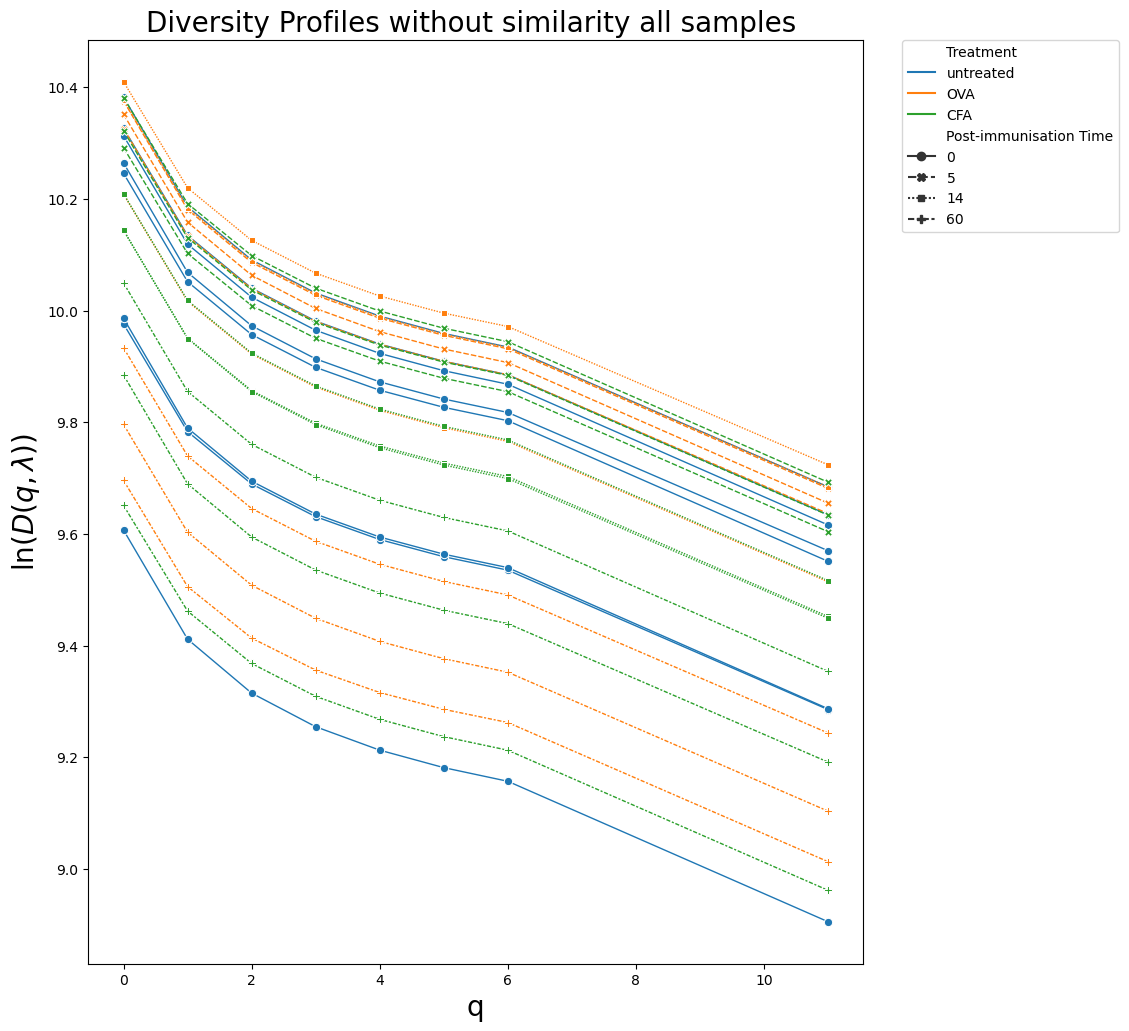

In [100]:
plt.figure(figsize=(10,12))
sns.color_palette("colorblind")
ax =sns.lineplot(data=divP_identity_plt_df, x="q", y="qDZ", hue="Treatment", style="Post-immunisation Time", units="sample_name", markers=True, estimator = None, lw=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.xlabel("q", fontsize = 20)
plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
plt.title("Diversity Profiles without similarity all samples ", fontsize = 20)
plt.savefig(wdir_path + "Diversity_profiles_ID_all_samples.png", bbox_inches='tight')
plt.show()
plt.close()
    



## All samples
### important features corrplot

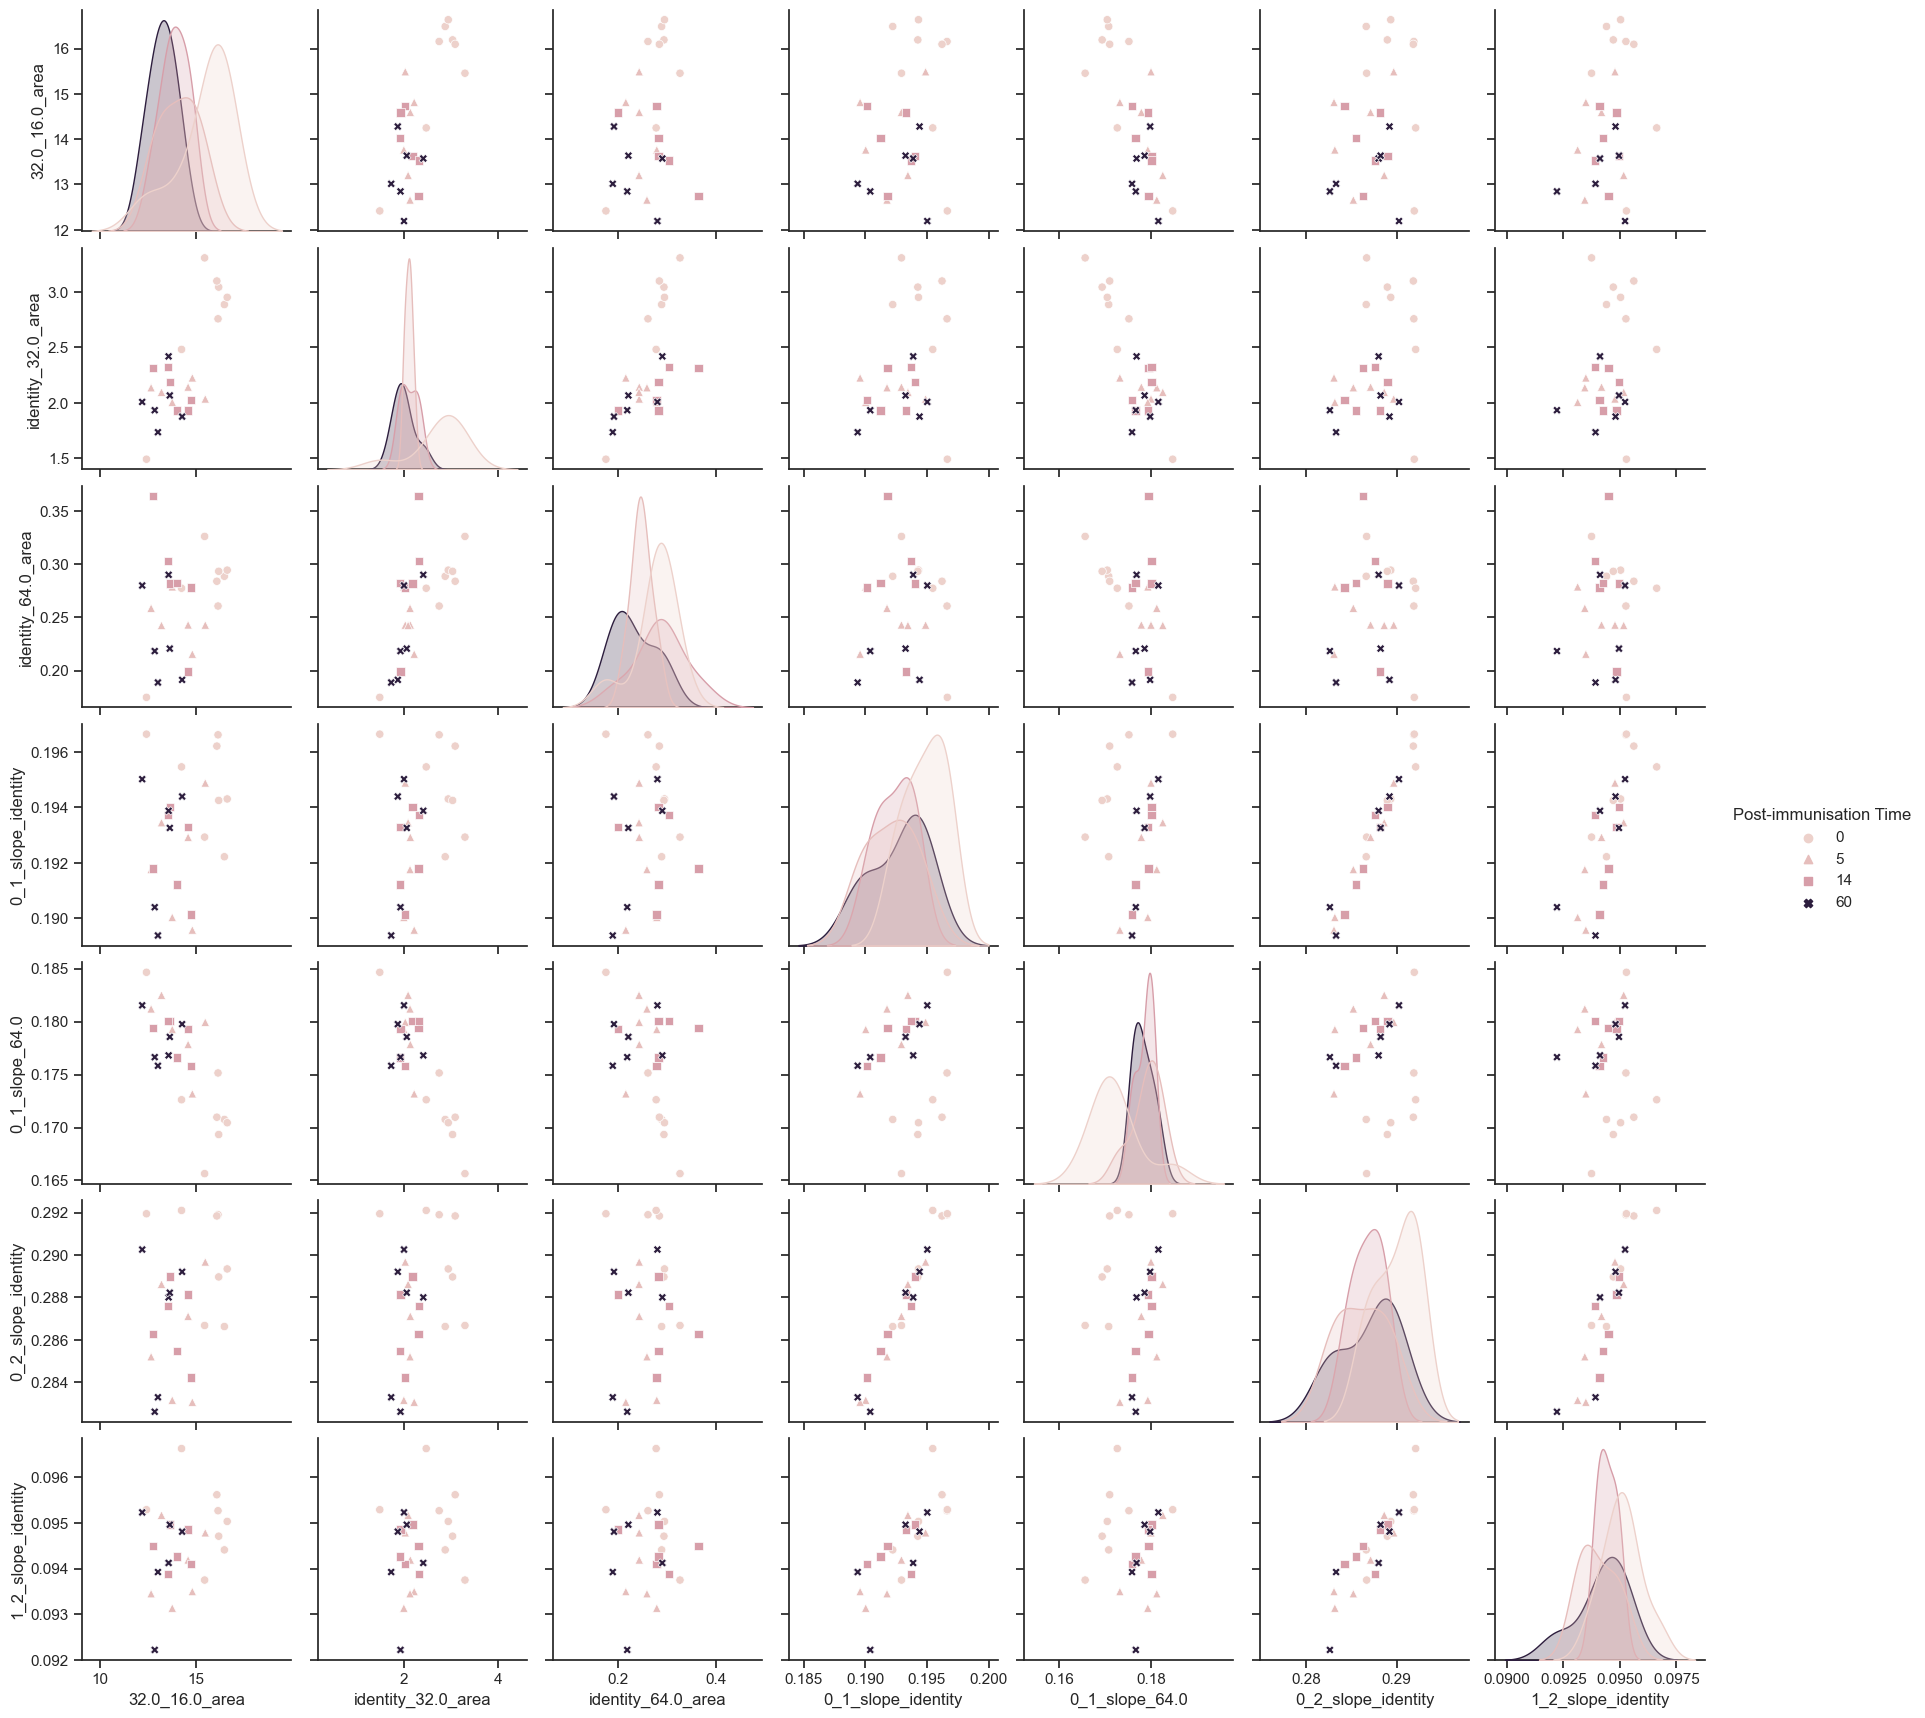

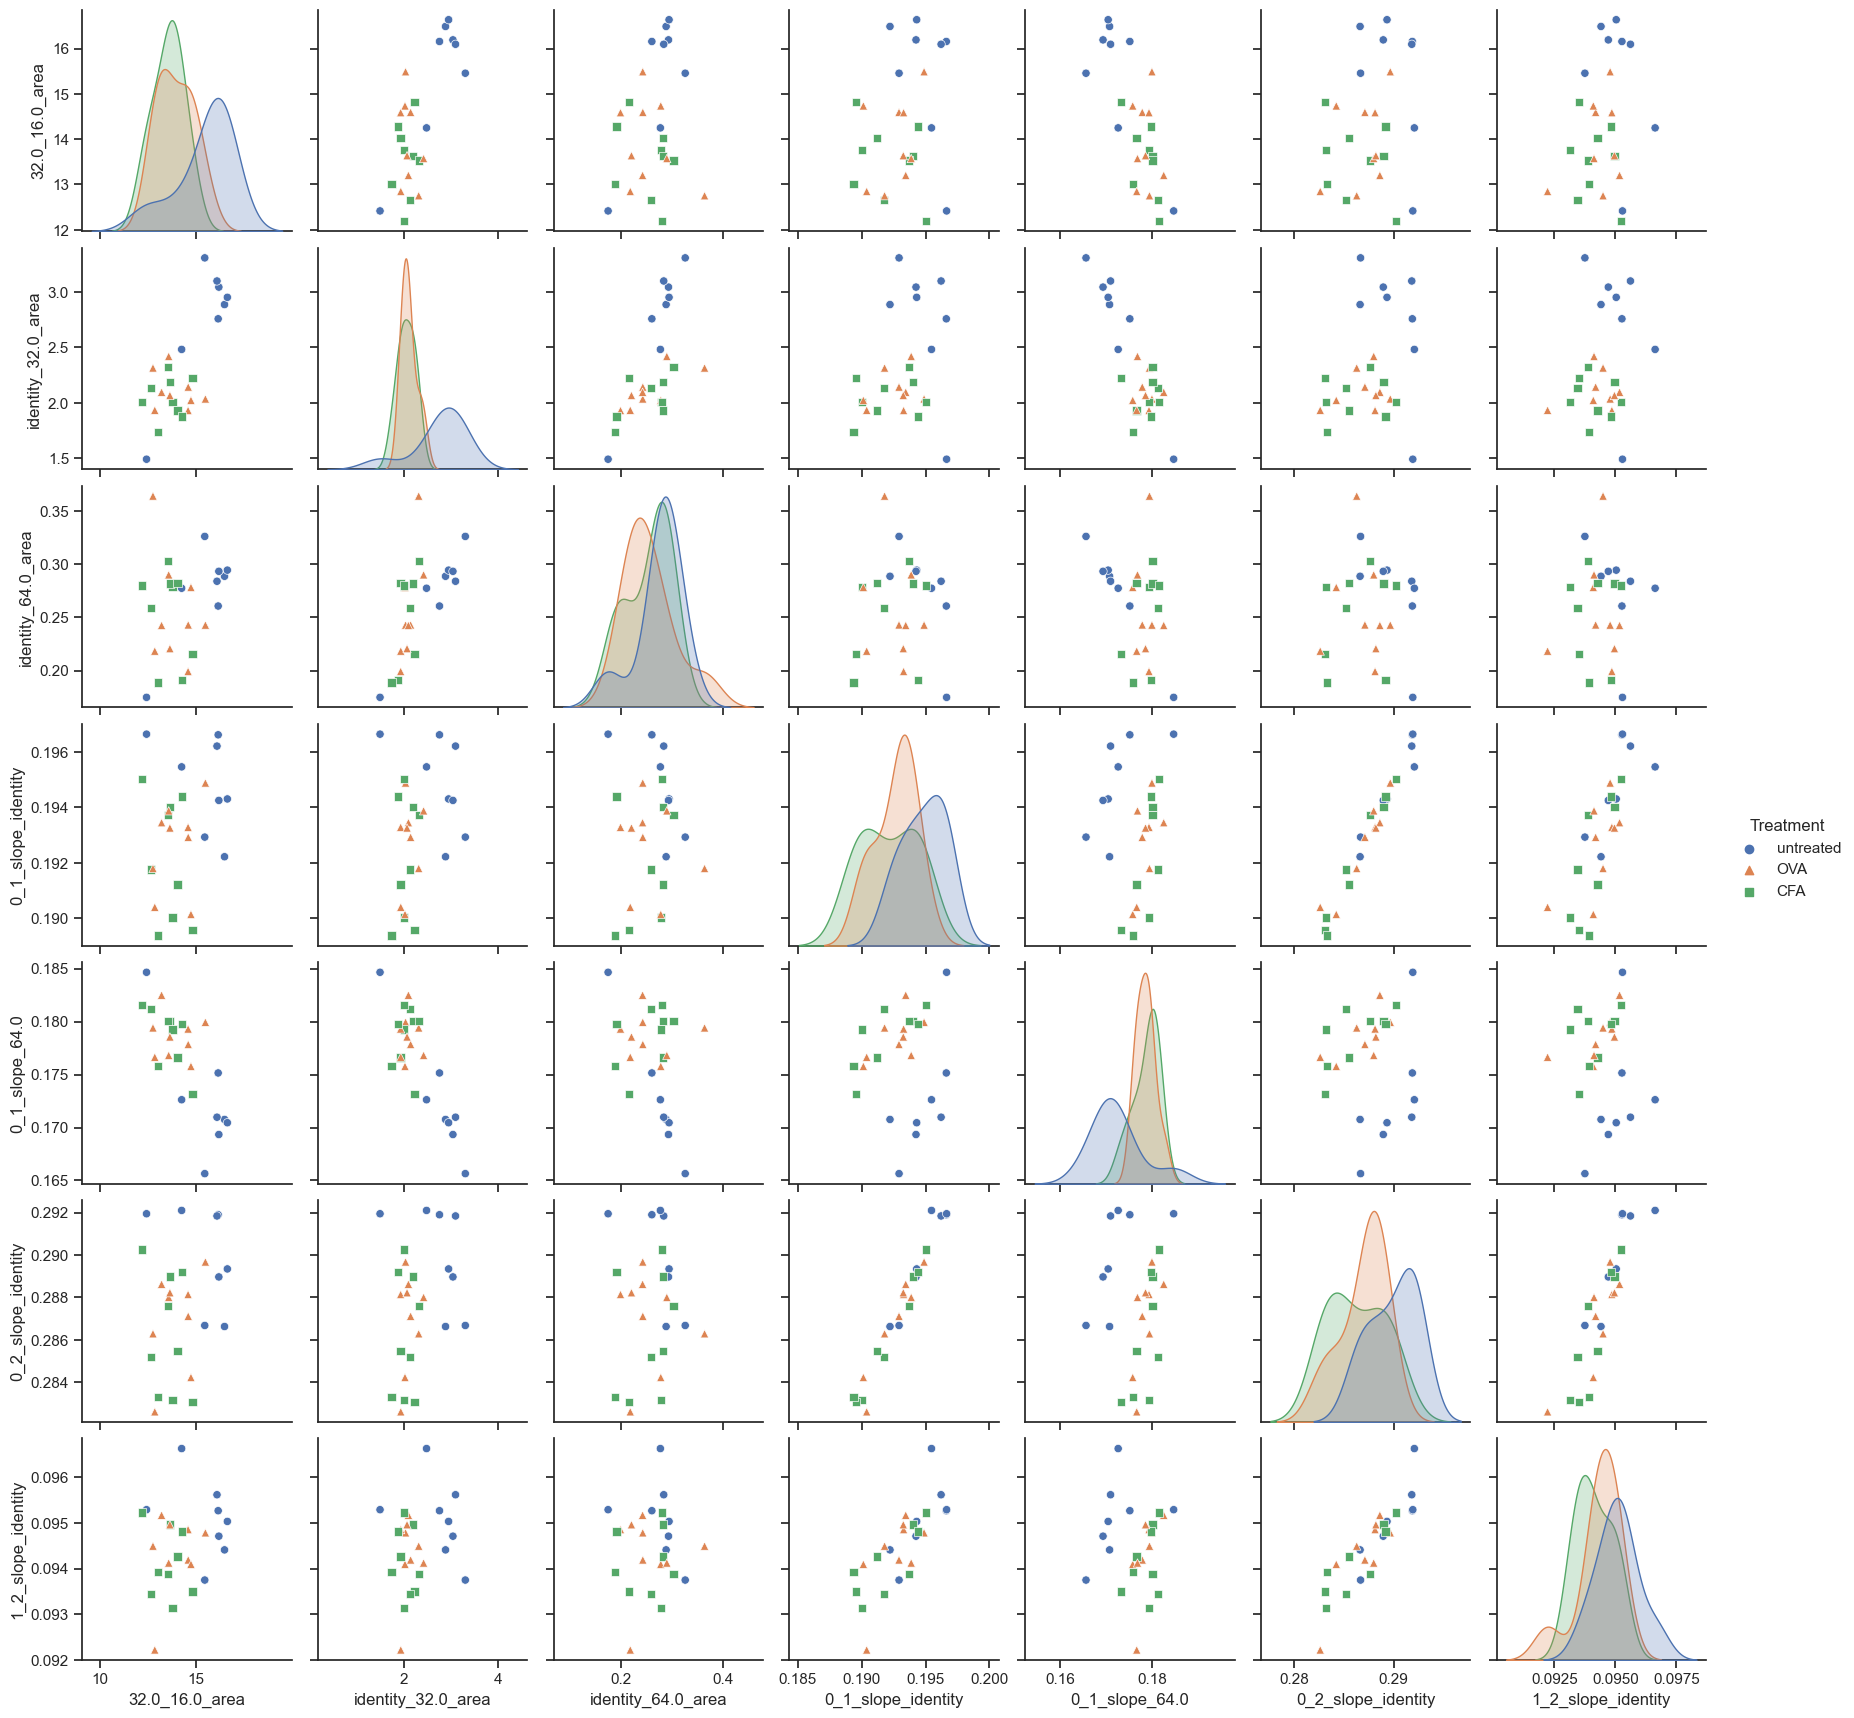

In [101]:
all_features = divP_features.copy()
important_ft = ["32.0_16.0_area", 
                "identity_32.0_area",
                "identity_64.0_area", 
                "0_1_slope_identity", 
                "0_1_slope_64.0", 
                "0_2_slope_identity", 
                "1_2_slope_identity",  
                "Treatment", 
               "Post-immunisation Time"]
divP_impr_ft = divP_features[important_ft]

sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="Post-immunisation Time", markers = ["o", "^", "s", "X"])
pairplot.savefig(wdir_path + "features_pairplot_timepoint.pdf")
pairplot

divP_impr_ft = divP_impr_ft.drop(['Post-immunisation Time'], axis=1)
sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="Treatment", markers = ["o", "^", "s"])
pairplot.savefig(wdir_path + "features_pairplot_treatment.pdf")
pairplot


### Selected features scatterplot 

In [102]:
def plot_selected_ft_scatterplot(ft1, ft2, hue_cat, style_cat, xlabel_f1, ylabel_ft2, wdir_path, divP_features_df, legend_opt = True):
    fig, ax = plt.subplots(figsize=(8,8))
    cmap = sns.color_palette("colorblind", len(list(set(divP_features_df[hue_cat]))))
    p = sns.scatterplot(x=ft1, y=ft2, 
                     data=divP_features_df,
                     hue=hue_cat, palette=cmap,  
                     style = style_cat, 
                     s = 140, legend = legend_opt
                     )
    if legend_opt:
        p.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(fontsize = 20, rotation=45)
    plt.yticks(fontsize = 20)
    plt.xlabel(xlabel_f1, fontsize = 26)
    plt.ylabel(ylabel_ft2, fontsize = 26)
    plt.tight_layout()
    if not os.path.isdir(wdir_path):
        os.makedirs(wdir_path, exist_ok=False)
    plt.savefig(wdir_path  + ft1 + "_" + ft2 + "_scatterplot_w_legend"+ str(legend_opt)+ ".pdf")
    plt.show()
    plt.close()


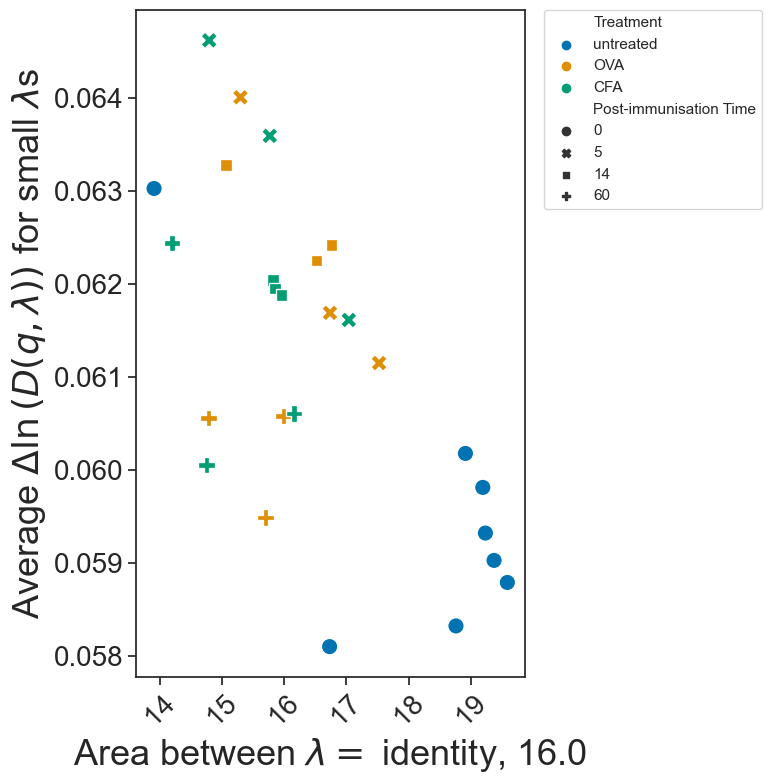

In [103]:
# delta lambda vs ID 16 area
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, True)


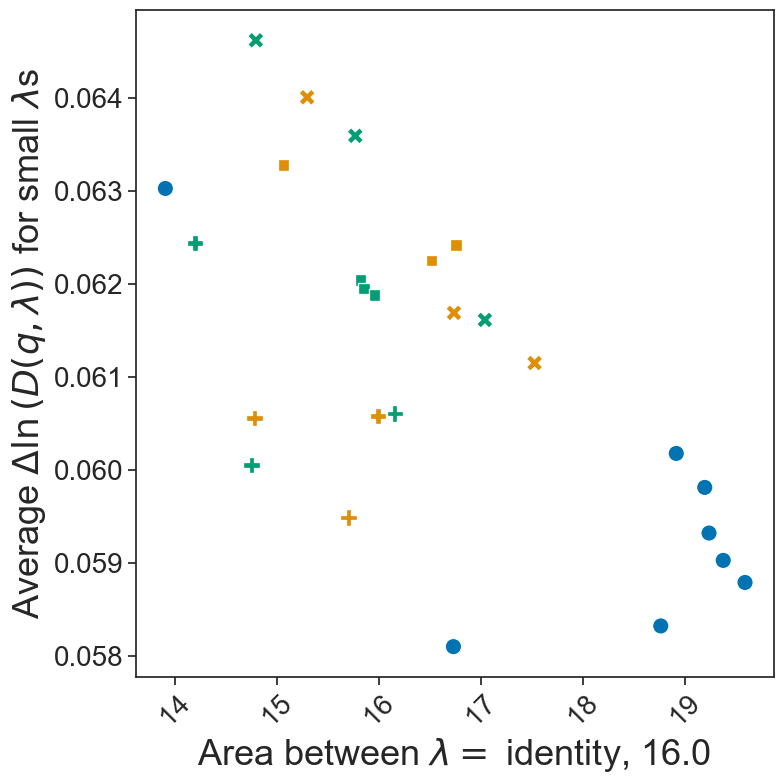

In [104]:
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


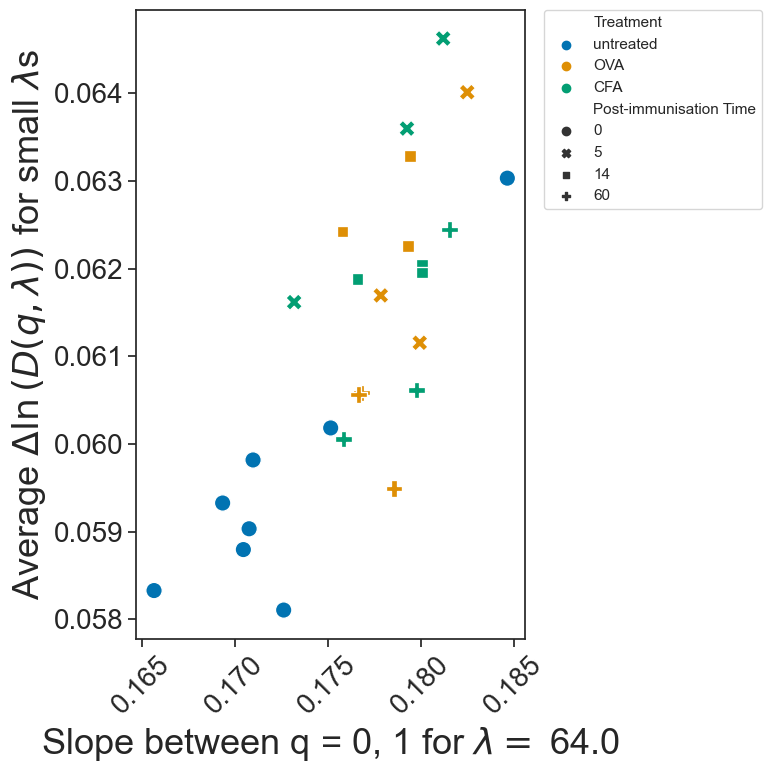

In [105]:
# delta lambda vs 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features)


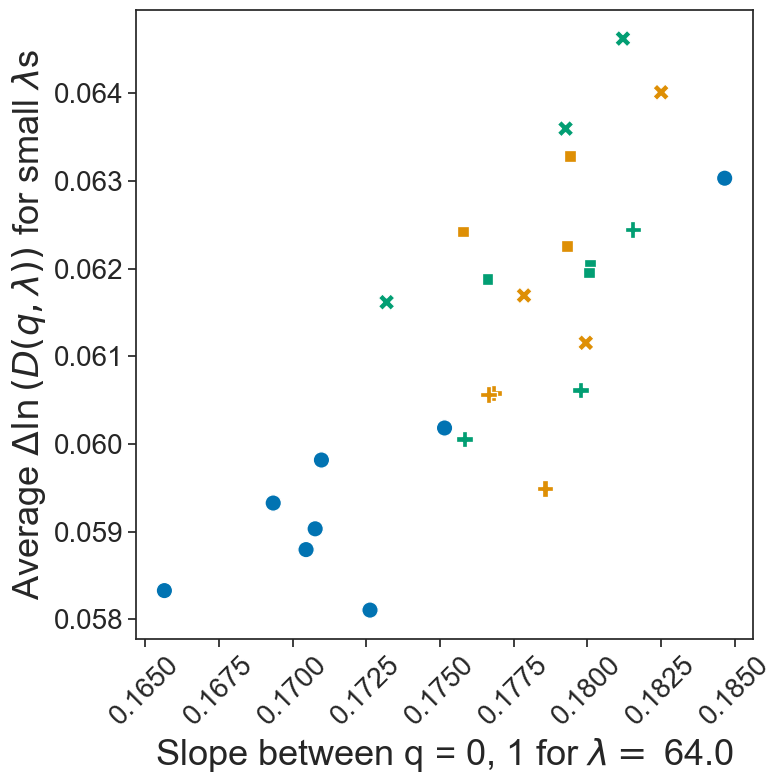

In [106]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


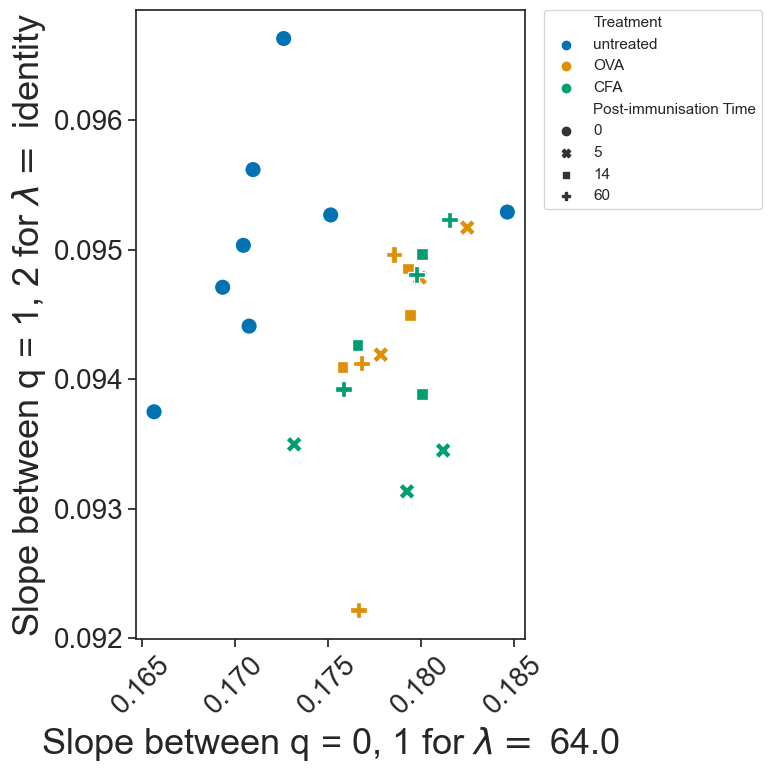

In [107]:
# 1-2 slope ID 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

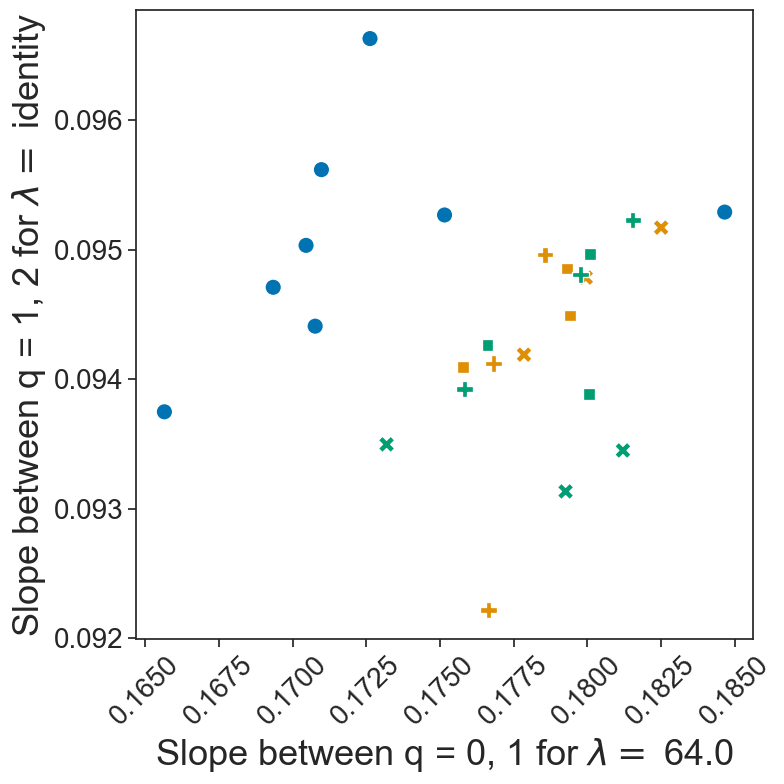

In [108]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

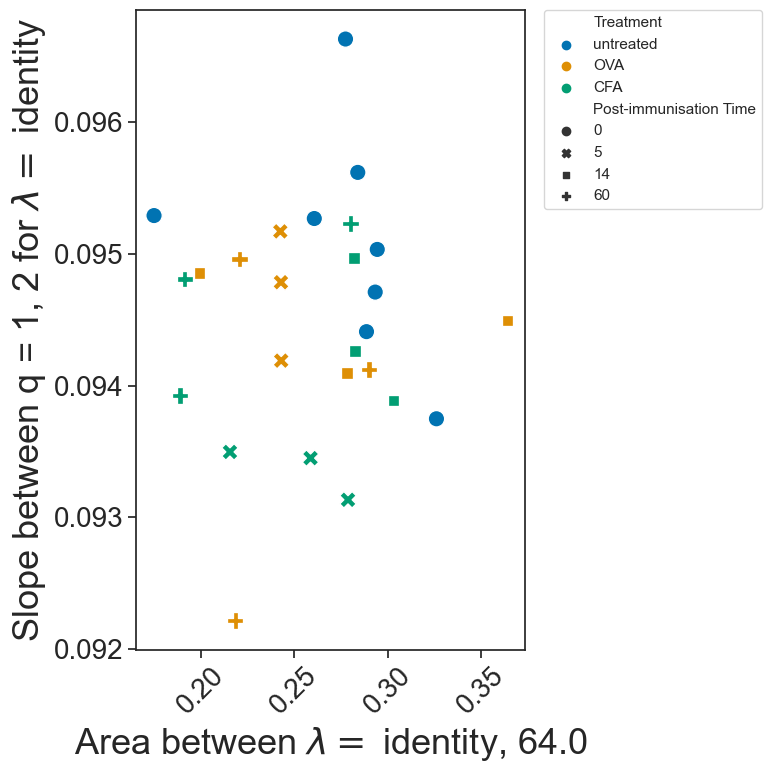

In [109]:
# 1-2 slope ID  ID 64 area

plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

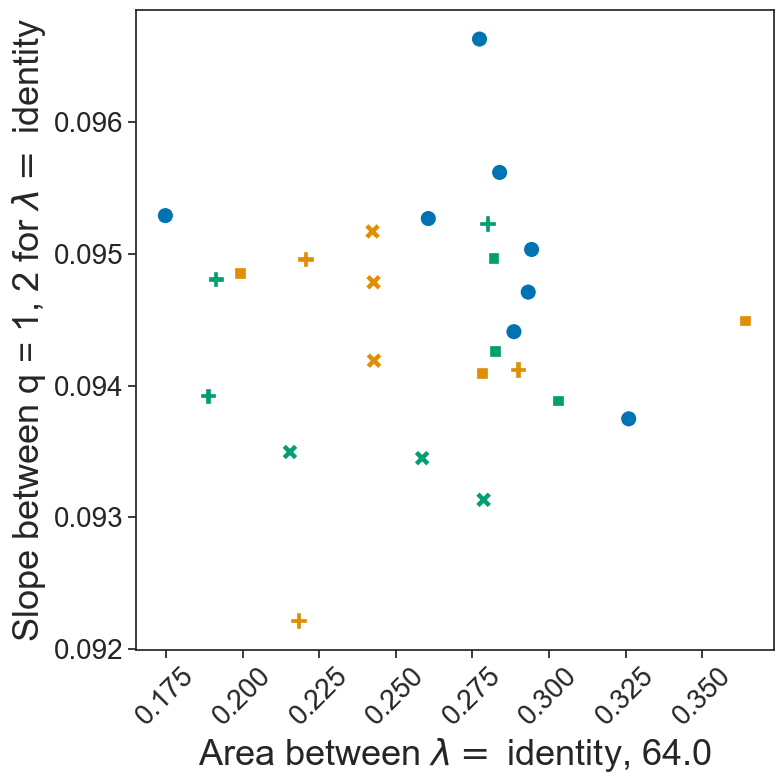

In [110]:
plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

### Lineplot of areas and slope 


In [111]:
hm_ft_df =divP_features[["sample_name", "Treatment", "Post-immunisation Time" ,"Average area for small lambdas","identity_16.0_area","0_1_slope_identity"]]

hm_ft_df["sample_name"] = [" ".join([row["Treatment"], " ", str(row["Post-immunisation Time"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
hm_ft_df["Regime"] = [" ".join([row["Treatment"], " Day ", str(row["Post-immunisation Time"])]) for index,row in hm_ft_df.iterrows()]
#hm_ft_df = hm_ft_df.set_index("sample_name")
hm_ft_df = hm_ft_df.sort_values(by=['Post-immunisation Time', "Treatment"])
hm_ft_df


/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50090/3406630853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["sample_name"] = [" ".join([row["Treatment"], " ", str(row["Post-immunisation Time"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50090/3406630853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["Regime"] = [" ".join([row["Treatment"], " Day ", str(row["Post-immunisation Time"])]) 

sample_name  Treatment  Post-immunisation Time  \
0   untreated   0   CPX1A_GGA  untreated                       0   
1   untreated   0   CPX1A_TTG  untreated                       0   
2   untreated   0   CPX1B_CAC  untreated                       0   
3   untreated   0   EAE1A_GGA  untreated                       0   
4   untreated   0   EAE1A_TTG  untreated                       0   
5   untreated   0   EAE1B_CCG  untreated                       0   
6   untreated   0   EAE1B_TTG  untreated                       0   
7     untreated   0   SB1_TGC  untreated                       0   
11          CFA   5   SB1_TTG        CFA                       5   
12          CFA   5   SB1_CCG        CFA                       5   
13          CFA   5   SB1_AAA        CFA                       5   
8           OVA   5   SB1_GTC        OVA                       5   
9           OVA   5   SB1_CAC        OVA                       5   
10          OVA   5   SB1_ATT        OVA                       5   
16         CFA   14   SB1_GCT        CFA                      14   
17         CFA   14   SB1_CTA        CFA                      14   
18         CFA   14   SB1_ACC        CFA                      14   
14         OVA   14   SB1_GAG        OVA                      14   
15         OVA   14   SB1_AGG        OVA                      14   
19         OVA   14   SB1_TAT        OVA                      14   
21         CFA   60   SB2_ATT        CFA                      60   
22         CFA   60   SB2_CCG        CFA                      60   
23         CFA   60   SB2_CGT        CFA                      60   
20         OVA   60   SB2_GCT        OVA                      60   
24         OVA   60   SB2_CAC        OVA                      60   
25         OVA   60   SB2_GTC        OVA                      60   

    Average area for small lambdas  identity_16.0_area  0_1_slope_identity  \
0                         0.060182           18.913259            0.196628   
1                         0.059032           19.373238            0.192219   
2                         0.058794           19.586562            0.194309   
3                         0.059326           19.233970            0.194256   
4                         0.059817           19.192278            0.196220   
5                         0.058104           16.730903            0.195468   
6                         0.058327           18.761478            0.192929   
7                         0.063032           13.909759            0.196652   
11                        0.063598           15.769930            0.190027   
12                        0.061618           17.039012            0.189570   
13                        0.064626           14.796379            0.191756   
8                         0.061154           17.525364            0.194888   
9                         0.061694           16.736413            0.192925   
10                        0.064013           15.298332            0.193452   
16                        0.062047           15.819228            0.194021   
17                        0.061955           15.857470            0.193720   
18                        0.061884           15.958669            0.191217   
14                        0.063286           15.067606            0.191795   
15                        0.062424           16.758885            0.190135   
19                        0.062258           16.517524            0.193284   
21                        0.062445           14.201323            0.195024   
22                        0.060614           16.156225            0.194397   
23                        0.060058           14.751261            0.189371   
20                        0.060584           15.992247            0.193880   
24                        0.060562           14.781503            0.190394   
25                        0.059492           15.703396            0.193261   

               Regime  
0   untreated  Day  0  
1   untreated  Day  0  
2 

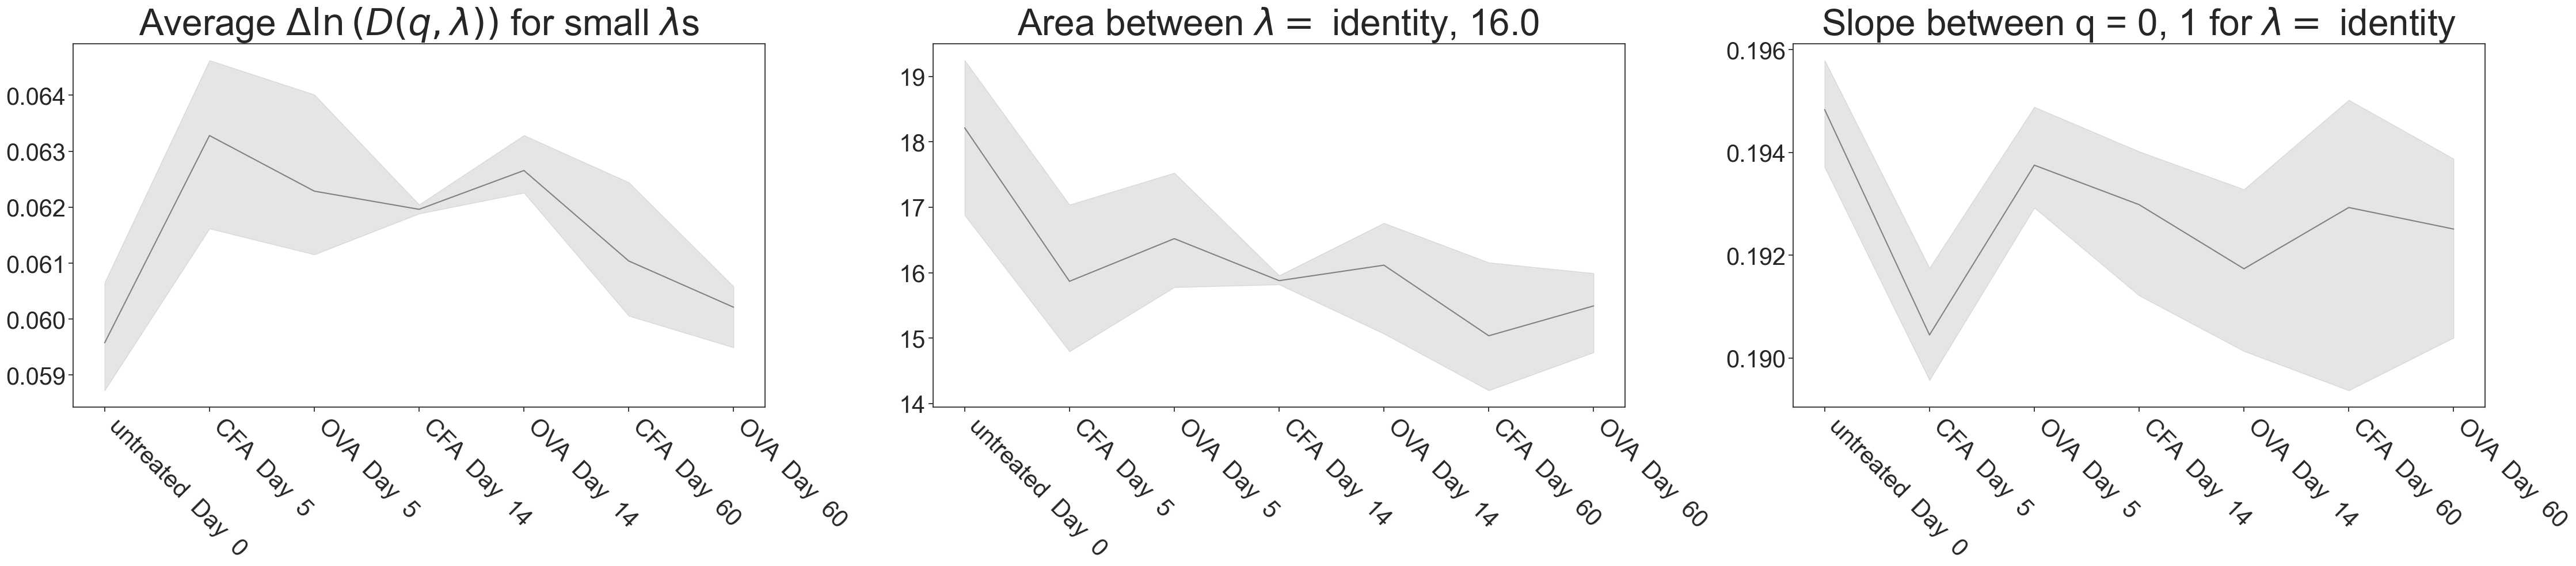

In [112]:
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)
plt.rc('axes', labelsize=46) 

fig, ax = plt.subplots(1, 3, figsize=(45, 10), sharey=False, sharex = True)
p1 = sns.lineplot(x="Regime", y="Average area for small lambdas", data=hm_ft_df, sort=False, ax=ax[0], color = "gray")
p2 = sns.lineplot(x="Regime", y="identity_16.0_area", data=hm_ft_df, sort=False, ax=ax[1], color = "gray")
p3 = sns.lineplot(x="Regime", y="0_1_slope_identity", data=hm_ft_df, sort=False, ax=ax[2], color = "gray")

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

p1.set_title('Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s', fontsize = 46)
p2.set_title('Area between $\lambda =$ identity, 16.0 ', fontsize = 46)
p3.set_title('Slope between q = 0, 1 for $\lambda =$ identity', fontsize = 46)

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=-45, ha="left")

plt.tight_layout()

plt.savefig(wdir_path + "lineplot_areas_slope.pdf")

### PCA on features 

In [113]:
post_imm_time_df = divP_features["Post-immunisation Time"]
treatment_df = divP_features["Treatment"]
sample_names_df = divP_features["sample_name"]

In [114]:
divP_features_treatment_time = divP_features.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"], axis=1)

divP_features_treatment_time

identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.260631            2.756932           18.913259   
1             0.288580            2.885291           19.373238   
2             0.294345            2.950367           19.586562   
3             0.293246            3.042477           19.233970   
4             0.283910            3.097450           19.192278   
5             0.277341            2.481461           16.730903   
6             0.326039            3.305567           18.761478   
7             0.174812            1.492959           13.909759   
8             0.242772            2.035855           17.525364   
9             0.242912            2.143065           16.736413   
10            0.242428            2.096440           15.298332   
11            0.278679            2.005517           15.769930   
12            0.215468            2.225527           17.039012   
13            0.258617            2.136906           14.796379   
14            0.364003            2.314711           15.067606   
15            0.278142            2.023394           16.758885   
16            0.281940            2.187346           15.819228   
17            0.302964            2.324330           15.857470   
18            0.282334            1.930260           15.958669   
19            0.199149            1.931574           16.517524   
20            0.289961            2.418929           15.992247   
21            0.279932            2.008576           14.201323   
22            0.191251            1.876657           16.156225   
23            0.188761            1.736011           14.751261   
24            0.218301            1.934085           14.781503   
25            0.220617            2.066994           15.703396   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0           39.924540          54.035712          61.896686   
1           40.184230          54.007147          61.705502   
2           40.223322          53.962402          61.622793   
3           39.603541          53.376762          61.090749   
4           39.550286          53.378893          61.139037   
5           35.990586          49.269930          56.768277   
6           38.416650          51.821665          59.365238   
7           35.582325          50.473325          58.730297   
8           39.243736          53.716507          61.729939   
9           38.588524          53.224953          61.322685   
10          37.623734          52.780968          61.168575   
11          38.074175          53.136208          61.472763   
12          38.510385          53.048877          61.122315   
13          37.154123          52.438478          60.906481   
14          37.065970          52.006030          60.284117   
15          38.838321          53.641213          61.829386   
16          37.296518          51.882722          59.990414   
17          37.355165          51.920496          60.016630   
18          37.710753          52.366612          60.482655   
19          38.632226          53.422562          61.592077   
20          36.717092          50.854406          58.738682   
21          35.369087          49.983247          58.120936   
22          37.366893          51.612680          59.528351   
23          35.070322          49.045856          56.860609   
24          35.184977          49.260125          57.126763   
25          36.260480          50.170838          57.918826   

    identity_1.5_area  identity_1.0_area  identity_0.75_area  \
0           63.937375          66.006408           67.051254   
1           63.704972          65.732856           66.757205   
2           63.613711          65.633445           66.653865   
3           63.097676          65.134199           66.163266   
4           63.159935          65.211535           66.248578   
5           58.726139          60.715794           61.722284   
6           61.332559          63.330989           64.341623   
7      

In [115]:
divP_features_treatment_time.shape

(26, 187)

In [116]:
observables = [col for col in list(divP_features_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x = divP_features_treatment_time.loc[:, observables].values
# Separating out the target
y = divP_features_treatment_time.loc[:,'Treatment'].values

In [117]:
x.shape

(26, 185)

In [118]:
x.mean(), x.std()

(20.00044510076312, 25.35292362537198)

In [119]:
x_scaled = StandardScaler().fit_transform(x)

In [120]:
x_scaled.mean(), x_scaled.std()

(-3.416070845000482e-17, 1.0)

In [121]:
pca_scaled = decomposition.PCA(n_components=26)
principalComponents_scaled = pca_scaled.fit_transform(x_scaled)

principalDf_scaled = pd.DataFrame(data = principalComponents_scaled)
principalDf_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_scaled)]
finalDf_scaled = pd.concat([principalDf_scaled, divP_features_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



In [122]:
def plotPCA(pca_scaled, colour_category, style_category, final_Df, wdir_path, fig_name, legend):
    """
    INPUT:  pca_scaled: pca object
            colour_category: string denoting a categorical var to colour by
            style_category: string denoting a categorical var for the point shape 
            final_Df: DataFrame with principal components and categorical variables
            wdir_path: path to working directory
            fig_name: string for figure name, ending with the extension pdf or png
            legend: True or False
            
    OUTPUT: 
            PCA figure with the aspect ratio corresponding to the principal components values 
    """
    per_PC1 = int(round(pca_scaled.explained_variance_ratio_[0]*100, 0))
    per_PC2 = int(round(pca_scaled.explained_variance_ratio_[1]*100, 0))
    if per_PC1 != 0 and per_PC2 != 0:
        fig, ax = plt.subplots(figsize=(per_PC1/5,per_PC2/5))
    else: 
        fig, ax = plt.subplots(figsize=(20,1))
    cmap = sns.color_palette("colorblind", len(list(set(final_Df[colour_category]))))
    if legend == True: 
        legend_box = "full"
    else: 
        legend_box = False
    p = sns.scatterplot(x="PC_0", y="PC_1",
                     hue=colour_category, style = style_category,
                     palette=cmap, s=100,
                     data=final_Df, 
                     alpha = 1, legend = legend_box)
    if legend == True: 
        p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tick_params(axis='both',          # changes apply which axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    left = False,
                    right = False,
                    labelbottom=False,
                    labelleft = False) # labels along the bottom edge are off
    #plt.xticks(fontsize = 13)
    #plt.yticks(fontsize = 13)
    plt.xlabel("".join(["PC1 (",str(per_PC1),"%)"]), fontsize = 15)
    plt.ylabel("".join(["PC2 (",str(per_PC2),"%)"]), fontsize = 15)
    plt.tight_layout()
    plt.savefig(wdir_path + fig_name, bbox_inches='tight')

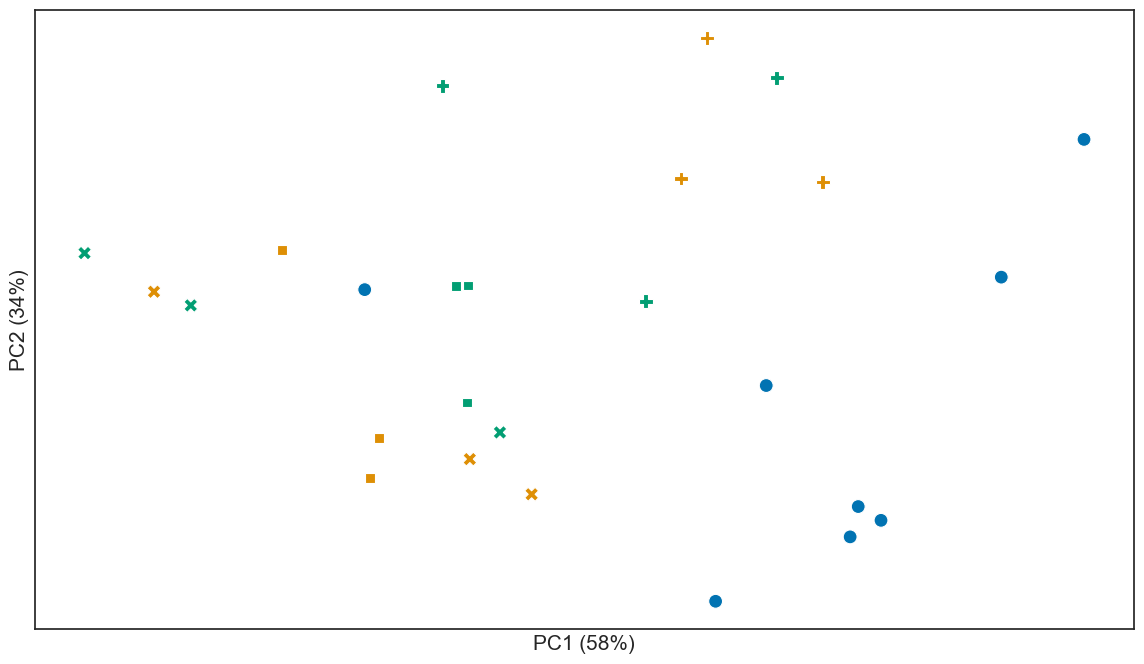

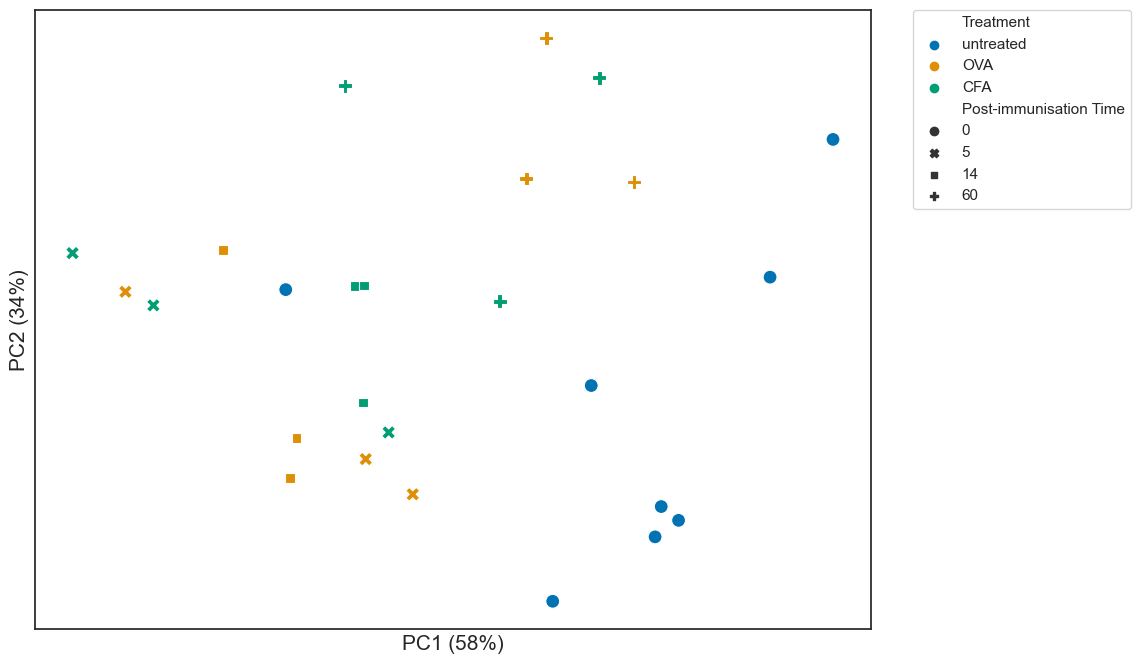

In [123]:
plotPCA(pca_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_scaled, wdir_path, "PCA_features.pdf", False)


plotPCA(pca_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_scaled, wdir_path, "PCA_features_w_legend.pdf", True)




### PCA on $D(q,\lambda)$

In [124]:
# remove PBS
divP1_all_df = divP1_all_df[divP1_all_df.Treatment != "PBS"]
divP1_all_df = divP1_all_df.reset_index(drop = "True")
divP1_all_df

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.061603  0.061597   0.06159  0.061584  0.061577  0.061571  0.061564   
1   0.060447  0.060439  0.060432  0.060424  0.060417   0.06041  0.060402   
2   0.060274  0.060266  0.060259  0.060251  0.060244  0.060236  0.060228   
3   0.060767   0.06076  0.060753  0.060745  0.060738  0.060731  0.060723   
4   0.061303  0.061293  0.061284  0.061275  0.061266  0.061257  0.061248   
5   0.059625  0.059615  0.059605  0.059595  0.059585  0.059575  0.059565   
6   0.059823  0.059814  0.059804  0.059794  0.059785  0.059775  0.059766   
7   0.064398   0.06439  0.064381  0.064373  0.064364  0.064356  0.064347   
8   0.062555  0.062547  0.062539  0.062531  0.062523  0.062516  0.062508   
9    0.06308  0.063073  0.063065  0.063057  0.063049  0.063041  0.063033   
10  0.065461  0.065451   0.06544   0.06543   0.06542   0.06541    0.0654   
11  0.065079  0.065069  0.065059  0.065048  0.065038  0.065028  0.065018   
12  0.062987  0.062978   0.06297  0.062962  0.062954  0.062946  0.062938   
13  0.066094  0.066084  0.066073  0.066063  0.066053  0.066042  0.066032   
14  0.064739  0.064729  0.064719  0.064709  0.064698  0.064688  0.064678   
15  0.063793  0.063785  0.063777  0.063769  0.063761  0.063753  0.063745   
16  0.063477  0.063467  0.063458  0.063448  0.063439  0.063429   0.06342   
17  0.063479  0.063469  0.063459   0.06345   0.06344   0.06343  0.063421   
18  0.063305  0.063297  0.063289  0.063281  0.063272  0.063264  0.063256   
19   0.06366  0.063652  0.063643  0.063635  0.063627  0.063618   0.06361   
20  0.062027  0.062017  0.062006  0.061996  0.061985  0.061975  0.061964   
21  0.063936  0.063925  0.063914  0.063902  0.063891   0.06388  0.063869   
22  0.062052  0.062043  0.062034  0.062024  0.062015  0.062006  0.061997   
23  0.061544  0.061534  0.061523  0.061512  0.061501  0.061491   0.06148   
24  0.062041  0.062029  0.062018  0.062006  0.061995  0.061984  0.061972   
25  0.060982  0.060972  0.060962  0.060952  0.060942  0.060932  0.060922   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_4 L_identity_q_5  \
0    0.052662  0.123102  0.123076  ...       9.990092       9.959071   
1    0.051631  0.120792  0.120762  ...       9.939987       9.909144   
2    0.050983  0.120446  0.120415  ...       9.923338       9.892347   
3    0.051815  0.121429  0.121399  ...       9.857314         9.8267   
4    0.052154  0.122503  0.122466  ...       9.872327       9.841569   
5    0.050307  0.119146  0.119106  ...       9.212529       9.181224   
6    0.050638  0.119543  0.119505  ...       9.589834       9.559092   
7    0.055997  0.128704   0.12867  ...       9.594347       9.563634   
8     0.05381  0.125016  0.124984  ...       9.986356       9.955662   
9     0.05439  0.126069  0.126037  ...       9.939561       9.908988   
10   0.056469  0.130835  0.130794  ...       9.962255        9.93119   
11   0.055808  0.130072  0.130031  ...        9.99919       9.968436   
12   0.054478  0.125881  0.125848  ...       9.909432       9.878795   
13   0.056947  0.132105  0.132062  ...       9.938185        9.90772   
14   0.055773  0.129389  0.129348  ...       9.821393       9.790193   
15   0.055293  0.127493   0.12746  ...      10.026067       9.995439   
16   0.054632  0.126862  0.126824  ...        9.75431       9.723325   
17   0.053939  0.126864  0.126825  ...       9.757417        9.72682   
18   0.054369  0.126518  0.126485  ...       9.823583       9.792591   
19   0.054869   0.12723  0.127196  ...       9.988808       9.957987   
20   0.053211  0.123963   0.12392  ...       9.545549       9.514744   
21   0.054789  0.127784  0.127738  ...       9.494009       9.463272   
22   0.053122  0.124011  0.123973  ...       9.660227       9.629411   
23   0.052377  0.122997  0.122953  ...       9.267728       9.236749   
24   0.053032  0.123991  0.123945  ...       9.315749       9.285654   
25   0.051715   0.12187   0.12183  ...       9.407376       9.376404   

   L_

In [125]:
post_imm_time_divP1_all_df = divP1_all_df["Post-immunisation Time"]
treatment_divP1_all_df = divP1_all_df["Treatment"]
sample_names_divP1_all_df = divP1_all_df["sample_name"]

In [126]:
divP1_all_df_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                ], axis=1)
divP1_all_df_treatment_time

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.061603  0.061597   0.06159  0.061584  0.061577  0.061571  0.061564   
1   0.060447  0.060439  0.060432  0.060424  0.060417   0.06041  0.060402   
2   0.060274  0.060266  0.060259  0.060251  0.060244  0.060236  0.060228   
3   0.060767   0.06076  0.060753  0.060745  0.060738  0.060731  0.060723   
4   0.061303  0.061293  0.061284  0.061275  0.061266  0.061257  0.061248   
5   0.059625  0.059615  0.059605  0.059595  0.059585  0.059575  0.059565   
6   0.059823  0.059814  0.059804  0.059794  0.059785  0.059775  0.059766   
7   0.064398   0.06439  0.064381  0.064373  0.064364  0.064356  0.064347   
8   0.062555  0.062547  0.062539  0.062531  0.062523  0.062516  0.062508   
9    0.06308  0.063073  0.063065  0.063057  0.063049  0.063041  0.063033   
10  0.065461  0.065451   0.06544   0.06543   0.06542   0.06541    0.0654   
11  0.065079  0.065069  0.065059  0.065048  0.065038  0.065028  0.065018   
12  0.062987  0.062978   0.06297  0.062962  0.062954  0.062946  0.062938   
13  0.066094  0.066084  0.066073  0.066063  0.066053  0.066042  0.066032   
14  0.064739  0.064729  0.064719  0.064709  0.064698  0.064688  0.064678   
15  0.063793  0.063785  0.063777  0.063769  0.063761  0.063753  0.063745   
16  0.063477  0.063467  0.063458  0.063448  0.063439  0.063429   0.06342   
17  0.063479  0.063469  0.063459   0.06345   0.06344   0.06343  0.063421   
18  0.063305  0.063297  0.063289  0.063281  0.063272  0.063264  0.063256   
19   0.06366  0.063652  0.063643  0.063635  0.063627  0.063618   0.06361   
20  0.062027  0.062017  0.062006  0.061996  0.061985  0.061975  0.061964   
21  0.063936  0.063925  0.063914  0.063902  0.063891   0.06388  0.063869   
22  0.062052  0.062043  0.062034  0.062024  0.062015  0.062006  0.061997   
23  0.061544  0.061534  0.061523  0.061512  0.061501  0.061491   0.06148   
24  0.062041  0.062029  0.062018  0.062006  0.061995  0.061984  0.061972   
25  0.060982  0.060972  0.060962  0.060952  0.060942  0.060932  0.060922   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_0 L_identity_q_1  \
0    0.052662  0.123102  0.123076  ...      10.382668       10.18604   
1    0.051631  0.120792  0.120762  ...      10.326825      10.134606   
2    0.050983  0.120446  0.120415  ...       10.31331      10.119001   
3    0.051815  0.121429  0.121399  ...      10.246013      10.051757   
4    0.052154  0.122503  0.122466  ...      10.264618      10.068398   
5    0.050307  0.119146  0.119106  ...       9.606832       9.411364   
6    0.050638  0.119543  0.119505  ...       9.976087       9.783158   
7    0.055997  0.128704   0.12867  ...       9.986311       9.789659   
8     0.05381  0.125016  0.124984  ...      10.375895      10.181007   
9     0.05439  0.126069  0.126037  ...      10.326137      10.133213   
10   0.056469  0.130835  0.130794  ...      10.351852      10.158401   
11   0.055808  0.130072  0.130031  ...      10.381676       10.19165   
12   0.054478  0.125881  0.125848  ...      10.291908      10.102338   
13   0.056947  0.132105  0.132062  ...      10.322198      10.130442   
14   0.055773  0.129389  0.129348  ...      10.208469      10.016674   
15   0.055293  0.127493   0.12746  ...      10.410004      10.219868   
16   0.054632  0.126862  0.126824  ...      10.143881        9.94986   
17   0.053939  0.126864  0.126825  ...      10.144275       9.950555   
18   0.054369  0.126518  0.126485  ...      10.209353      10.018136   
19   0.054869   0.12723  0.127196  ...      10.377265      10.183981   
20   0.053211  0.123963   0.12392  ...       9.933435       9.739555   
21   0.054789  0.127784  0.127738  ...        9.88461       9.689587   
22   0.053122  0.124011  0.123973  ...      10.049577        9.85518   
23   0.052377  0.122997  0.122953  ...       9.651108       9.461737   
24   0.053032  0.123991  0.123945  ...        9.69591       9.505515   
25   0.051715   0.12187   0.12183  ...       9.796236       9.602976   

   L_

In [127]:
divP1_all_df_treatment_time.shape

(26, 130)

In [128]:
observables = [col for col in list(divP1_all_df_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x_qDZ = divP1_all_df_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ = divP1_all_df_treatment_time.loc[:,'Treatment'].values

In [129]:
x_qDZ.shape

(26, 128)

In [130]:
x_qDZ.mean(), x_qDZ.std()

(2.9561764921148983, 3.7323594418943995)

In [131]:
x_qDZ_scaled = StandardScaler().fit_transform(x_qDZ)

In [132]:
x_qDZ_scaled.mean(), x_qDZ_scaled.std()

(3.8380756905986857e-16, 1.0)

In [133]:
pca_qDZ_scaled = decomposition.PCA(n_components=26)
principalComponents_qDZ_scaled = pca_qDZ_scaled.fit_transform(x_qDZ_scaled)

principalDf_qDZ_scaled = pd.DataFrame(data = principalComponents_qDZ_scaled)
principalDf_qDZ_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_scaled)]
finalDf_qDZ_scaled = pd.concat([principalDf_qDZ_scaled, divP1_all_df_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



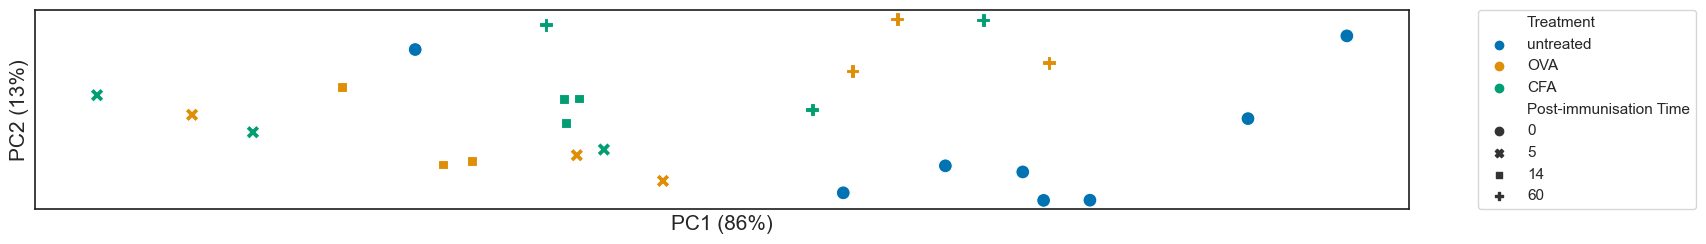

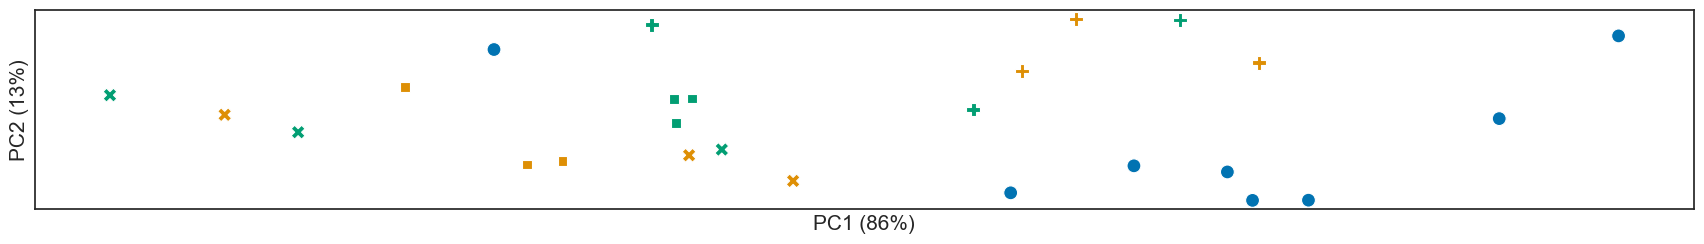

In [134]:
plotPCA(pca_qDZ_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ_w_legend.pdf", True)

plotPCA(pca_qDZ_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ.pdf", False)





### PCA on identity qD

In [135]:
col_without_identity = [colname for colname in list(divP1_all_df) if "L" in colname] 
col_without_identity = [colname for colname in col_without_identity if "identity" not in colname] 

In [136]:
divP1_identity_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                  ] + col_without_identity, axis=1)









divP1_identity_treatment_time



L_identity_q_0 L_identity_q_1 L_identity_q_2 L_identity_q_3 L_identity_q_4  \
0       10.382668       10.18604      10.090771      10.031515       9.990092   
1       10.326825      10.134606      10.040196       9.981222       9.939987   
2        10.31331      10.119001      10.023967       9.964741       9.923338   
3       10.246013      10.051757       9.957047        9.89828       9.857314   
4       10.264618      10.068398       9.972779       9.913549       9.872327   
5        9.606832       9.411364       9.314733         9.2545       9.212529   
6        9.976087       9.783158       9.689409       9.630853       9.589834   
7        9.986311       9.789659       9.694368       9.635418       9.594347   
8       10.375895      10.181007      10.086222      10.027399       9.986356   
9       10.326137      10.133213      10.039023       9.980448       9.939561   
10      10.351852      10.158401       10.06323      10.003797       9.962255   
11      10.381676       10.19165      10.098516      10.040155        9.99919   
12      10.291908      10.102338      10.008841       9.950358       9.909432   
13      10.322198      10.130442      10.036991       9.978845       9.938185   
14      10.208469      10.016674        9.92218       9.862961       9.821393   
15      10.410004      10.219868      10.125774      10.067058      10.026067   
16      10.143881        9.94986       9.854893       9.795701        9.75431   
17      10.144275       9.950555       9.856668       9.798259       9.757417   
18      10.209353      10.018136       9.923873       9.864909       9.823583   
19      10.377265      10.183981      10.089126       10.03005       9.988808   
20       9.933435       9.739555       9.645432       9.586687       9.545549   
21        9.88461       9.689587       9.594355       9.535204       9.494009   
22      10.049577        9.85518        9.76037        9.70141       9.660227   
23       9.651108       9.461737       9.367813        9.30899       9.267728   
24        9.69591       9.505515       9.413298       9.355905       9.315749   
25       9.796236       9.602976       9.508014       9.448785       9.407376   

   L_identity_q_5 L_identity_q_6 L_identity_q_11  Treatment  \
0        9.959071       9.934755        9.684169  untreated   
1        9.909144       9.885005        9.634171  untreated   
2        9.892347       9.868063        9.615946  untreated   
3          9.8267       9.802734        9.550801  untreated   
4        9.841569       9.817528        9.569825  untreated   
5        9.181224       9.156765        8.905166  untreated   
6        9.559092       9.534995        9.285201  untreated   
7        9.563634       9.539566        9.286756  untreated   
8        9.955662       9.931623        9.681462        OVA   
9        9.908988       9.885049         9.63634        OVA   
10        9.93119       9.906877        9.655044        OVA   
11       9.968436        9.94429        9.692556        CFA   
12       9.878795       9.854794        9.603888        CFA   
13        9.90772       9.883824        9.633578        CFA   
14       9.790193       9.765711        9.514042        OVA   
15       9.995439       9.971482        9.723709        OVA   
16       9.723325       9.699054        9.448852        CFA   
17        9.72682       9.702825        9.452003        CFA   
18       9.792591       9.768278         9.51626        CFA   
19       9.957987       9.933878        9.684208        OVA   
20       9.514744       9.490624        9.243265        OVA   
21       9.463272       9.439248        9.191177        CFA   
22       9.629411       9.605268        9.353661        CFA   
23       9.236749       9.212417        8.961458        CFA   
24       9.285654       9.262044        9.012748        OVA   
25       9.376404       9.352174        9.103255        OVA   

    Post-immunisation Time  
0                        0  
1                        0  
2                        0

In [137]:
observables = [col for col in list(divP1_identity_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x_qDZ_identity1 = divP1_identity_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ_identity1 = divP1_identity_treatment_time.loc[:,'Treatment'].values

In [138]:
x_qDZ_identity1.shape

(26, 8)

In [139]:
x_qDZ_identity1.mean(), x_qDZ_identity1.std()

(9.794507379945701, 0.30797629780522817)

In [140]:
x_qDZ_identity1_scaled = StandardScaler().fit_transform(x_qDZ_identity1)

In [141]:
x_qDZ_identity1_scaled.mean(), x_qDZ_identity1_scaled.std()

(7.985065600188626e-16, 1.0)

In [142]:
pca_qDZ_identity1_scaled = decomposition.PCA(n_components=8)
principalComponents_qDZ_identity1_scaled = pca_qDZ_identity1_scaled.fit_transform(x_qDZ_identity1_scaled)

principalDf_qDZ_identity1_scaled = pd.DataFrame(data = principalComponents_qDZ_identity1_scaled)
principalDf_qDZ_identity1_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_identity1_scaled)]
finalDf_qDZ_identity1_scaled = pd.concat([principalDf_qDZ_identity1_scaled, divP1_identity_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50090/2086500981.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


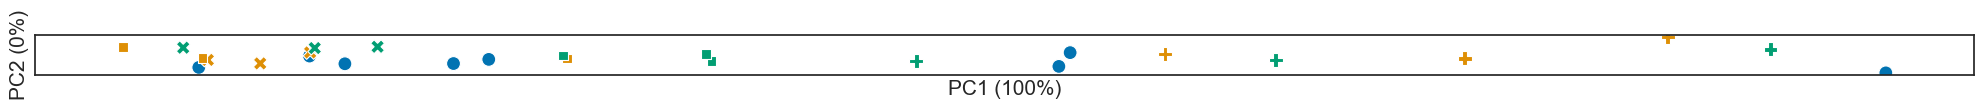

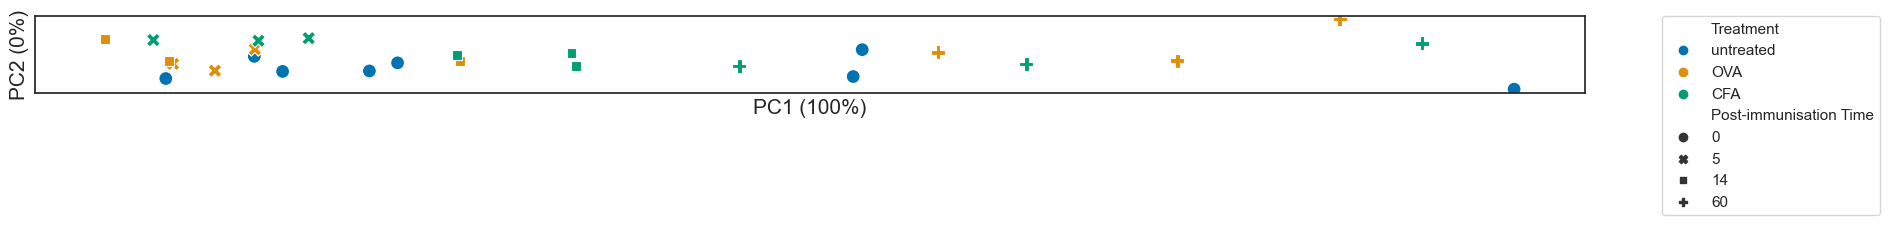

In [143]:
plotPCA(pca_qDZ_identity1_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity.pdf", False)

plotPCA(pca_qDZ_identity1_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity_w_legend.pdf", True)






### Exp(Shannon index) separation 

In [144]:
divP1_identity_q1_treatment_time = divP1_all_df[["L_identity_q_1", "Post-immunisation Time", "Treatment"]]

divP1_identity_q1_treatment_time



L_identity_q_1  Post-immunisation Time  Treatment
0        10.18604                       0  untreated
1       10.134606                       0  untreated
2       10.119001                       0  untreated
3       10.051757                       0  untreated
4       10.068398                       0  untreated
5        9.411364                       0  untreated
6        9.783158                       0  untreated
7        9.789659                       0  untreated
8       10.181007                       5        OVA
9       10.133213                       5        OVA
10      10.158401                       5        OVA
11       10.19165                       5        CFA
12      10.102338                       5        CFA
13      10.130442                       5        CFA
14      10.016674                      14        OVA
15      10.219868                      14        OVA
16        9.94986                      14        CFA
17       9.950555                      14        CFA
18      10.018136                      14        CFA
19      10.183981                      14        OVA
20       9.739555                      60        OVA
21       9.689587                      60        CFA
22        9.85518                      60        CFA
23       9.461737                      60        CFA
24       9.505515                      60        OVA
25       9.602976                      60        OVA

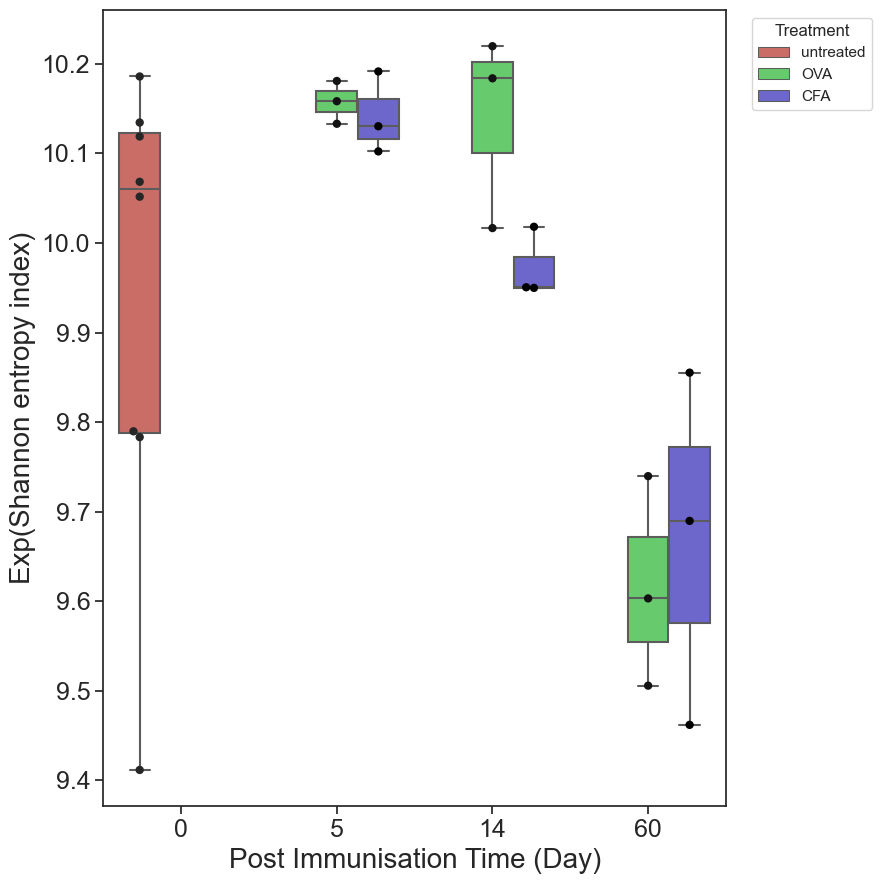

In [145]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q1_treatment_time["Treatment"]))))
p = sns.boxplot(x="Post-immunisation Time", y="L_identity_q_1", hue="Treatment",
                 data=divP1_identity_q1_treatment_time, palette=cmap)
p = sns.swarmplot(x="Post-immunisation Time", y="L_identity_q_1", hue="Treatment",data=divP1_identity_q1_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)

# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q1_treatment_time["Treatment"])))], labels[0:len(list(set(divP1_identity_q1_treatment_time["Treatment"])))], 
                   title = "Treatment", loc=2, bbox_to_anchor=(1.03, 1))


plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Post Immunisation Time (Day)", fontsize = 20)
plt.ylabel("Exp(Shannon entropy index)", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Exp_Shannon_entropy_barplot.pdf")

### Gini analogue separation

In [146]:
divP1_identity_q2_treatment_time = divP1_all_df[["L_identity_q_2", "Post-immunisation Time", "Treatment"]]

divP1_identity_q2_treatment_time



L_identity_q_2  Post-immunisation Time  Treatment
0       10.090771                       0  untreated
1       10.040196                       0  untreated
2       10.023967                       0  untreated
3        9.957047                       0  untreated
4        9.972779                       0  untreated
5        9.314733                       0  untreated
6        9.689409                       0  untreated
7        9.694368                       0  untreated
8       10.086222                       5        OVA
9       10.039023                       5        OVA
10       10.06323                       5        OVA
11      10.098516                       5        CFA
12      10.008841                       5        CFA
13      10.036991                       5        CFA
14        9.92218                      14        OVA
15      10.125774                      14        OVA
16       9.854893                      14        CFA
17       9.856668                      14        CFA
18       9.923873                      14        CFA
19      10.089126                      14        OVA
20       9.645432                      60        OVA
21       9.594355                      60        CFA
22        9.76037                      60        CFA
23       9.367813                      60        CFA
24       9.413298                      60        OVA
25       9.508014                      60        OVA

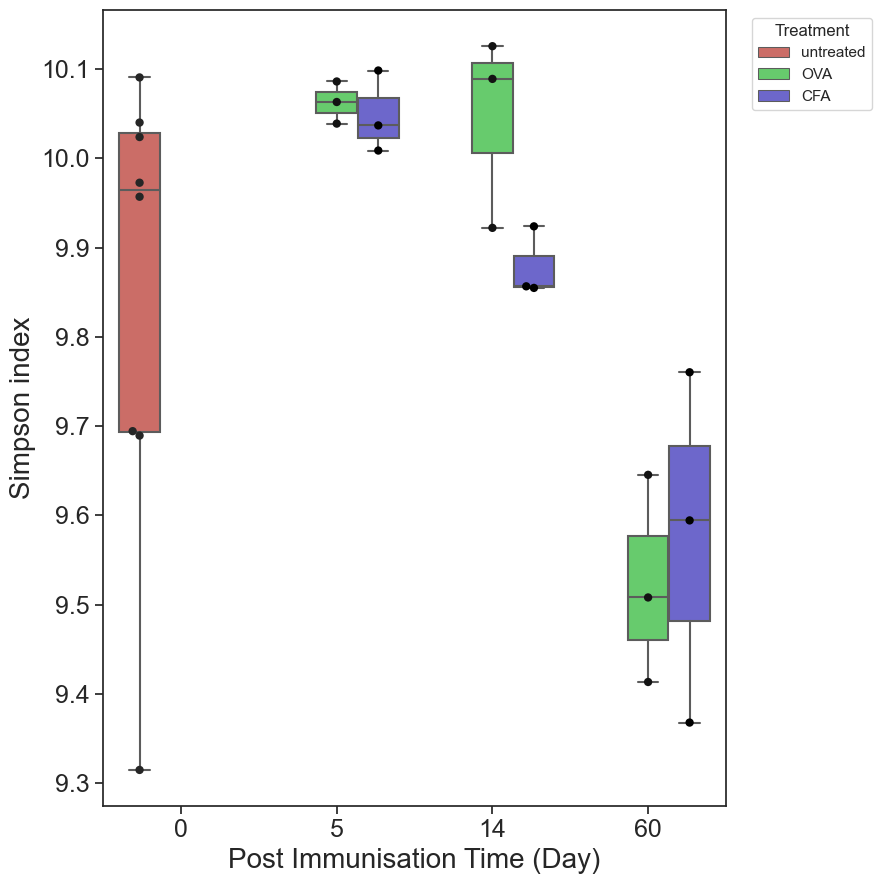

In [147]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q2_treatment_time["Treatment"]))))
p = sns.boxplot(x="Post-immunisation Time", y="L_identity_q_2", hue="Treatment",
                 data=divP1_identity_q2_treatment_time, palette=cmap)
p = sns.swarmplot(x="Post-immunisation Time", y="L_identity_q_2", hue="Treatment",data=divP1_identity_q2_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)
# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q2_treatment_time["Treatment"])))], labels[0:len(list(set(divP1_identity_q2_treatment_time["Treatment"])))], 
                   title = "Treatment", loc=2, bbox_to_anchor=(1.03, 1))


#p.legend(title = "Treatment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Post Immunisation Time (Day)", fontsize = 20)
plt.ylabel("Simpson index", fontsize = 20)

plt.tight_layout()
plt.savefig(wdir_path + "Gini_Simpson_index_barplot.pdf")

### Shannon vs Gini-Simpson 

In [148]:
divP_Shannon_Gini = divP1_identity_q2_treatment_time.copy()
divP_Shannon_Gini["L_identity_q_1"] = divP1_identity_q1_treatment_time["L_identity_q_1"]
divP_Shannon_Gini

L_identity_q_2  Post-immunisation Time  Treatment L_identity_q_1
0       10.090771                       0  untreated       10.18604
1       10.040196                       0  untreated      10.134606
2       10.023967                       0  untreated      10.119001
3        9.957047                       0  untreated      10.051757
4        9.972779                       0  untreated      10.068398
5        9.314733                       0  untreated       9.411364
6        9.689409                       0  untreated       9.783158
7        9.694368                       0  untreated       9.789659
8       10.086222                       5        OVA      10.181007
9       10.039023                       5        OVA      10.133213
10       10.06323                       5        OVA      10.158401
11      10.098516                       5        CFA       10.19165
12      10.008841                       5        CFA      10.102338
13      10.036991                       5        CFA      10.130442
14        9.92218                      14        OVA      10.016674
15      10.125774                      14        OVA      10.219868
16       9.854893                      14        CFA        9.94986
17       9.856668                      14        CFA       9.950555
18       9.923873                      14        CFA      10.018136
19      10.089126                      14        OVA      10.183981
20       9.645432                      60        OVA       9.739555
21       9.594355                      60        CFA       9.689587
22        9.76037                      60        CFA        9.85518
23       9.367813                      60        CFA       9.461737
24       9.413298                      60        OVA       9.505515
25       9.508014                      60        OVA       9.602976

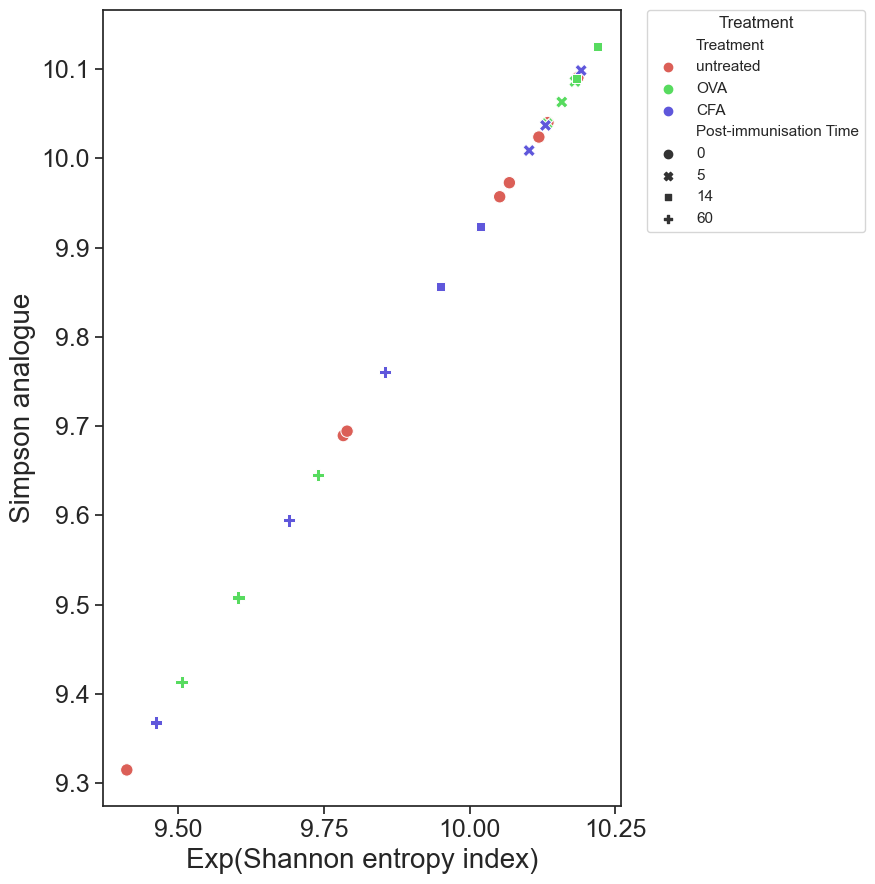

In [149]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP_Shannon_Gini["Treatment"]))))
p = sns.scatterplot(x="L_identity_q_1", y="L_identity_q_2", 
                     data=divP_Shannon_Gini,
                     hue="Treatment", palette=cmap,  
                     style = "Post-immunisation Time", 
                    s = 80
                   )




p.legend(title = "Treatment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Exp(Shannon entropy index)", fontsize = 20)
plt.ylabel("Simpson analogue", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Shannon_vs_Gini_Simpson_index_scatter_plot.pdf")




# Hierarchical clustering 

## Cluster divP features 

In [150]:
divP_features_HC = divP_features_treatment_time.copy()

divP_features_HC = divP_features_HC.set_index(["Treatment", "Post-immunisation Time"])

divP_features_HC

identity_64.0_area  identity_32.0_area  \
Treatment Post-immunisation Time                                           
untreated 0                                 0.260631            2.756932   
          0                                 0.288580            2.885291   
          0                                 0.294345            2.950367   
          0                                 0.293246            3.042477   
          0                                 0.283910            3.097450   
          0                                 0.277341            2.481461   
          0                                 0.326039            3.305567   
          0                                 0.174812            1.492959   
OVA       5                                 0.242772            2.035855   
          5                                 0.242912            2.143065   
          5                                 0.242428            2.096440   
CFA       5                                 0.278679            2.005517   
          5                                 0.215468            2.225527   
          5                                 0.258617            2.136906   
OVA       14                                0.364003            2.314711   
          14                                0.278142            2.023394   
CFA       14                                0.281940            2.187346   
          14                                0.302964            2.324330   
          14                                0.282334            1.930260   
OVA       14                                0.199149            1.931574   
          60                                0.289961            2.418929   
CFA       60                                0.279932            2.008576   
          60                                0.191251            1.876657   
          60                                0.188761            1.736011   
OVA       60                                0.218301            1.934085   
          60                                0.220617            2.066994   

                                  identity_16.0_area  identity_8.0_area  \
Treatment Post-immunisation Time                                          
untreated 0                                18.913259          39.924540   
          0                                19.373238          40.184230   
          0                                19.586562          40.223322   
          0                                19.233970          39.603541   
          0                                19.192278          39.550286   
          0                                16.730903          35.990586   
          0                                18.761478          38.416650   
          0                                13.909759          35.582325   
OVA       5                                17.525364          39.243736   
          5                                16.736413          38.588524   
          5                                15.298332          37.623734   
CFA       5                                15.769930          38.074175   
          5                                17.039012          38.510385   
          5                                14.796379          37.154123   
OVA       14                               15.067606          37.065970   
          14                               16.758885          38.838321   
CFA       14                               15.819228          37.296518   
          14                               15.857470          37.355165   
          14                               15.958669          37.710753   
OVA       14                               16.517524          38.632226   
          60                               15.992247          36.717092   
CFA       60                               14.201323          35.369087   
          60                               16.156225          37.366893   
          60                  

<Figure size 600x800 with 0 Axes>

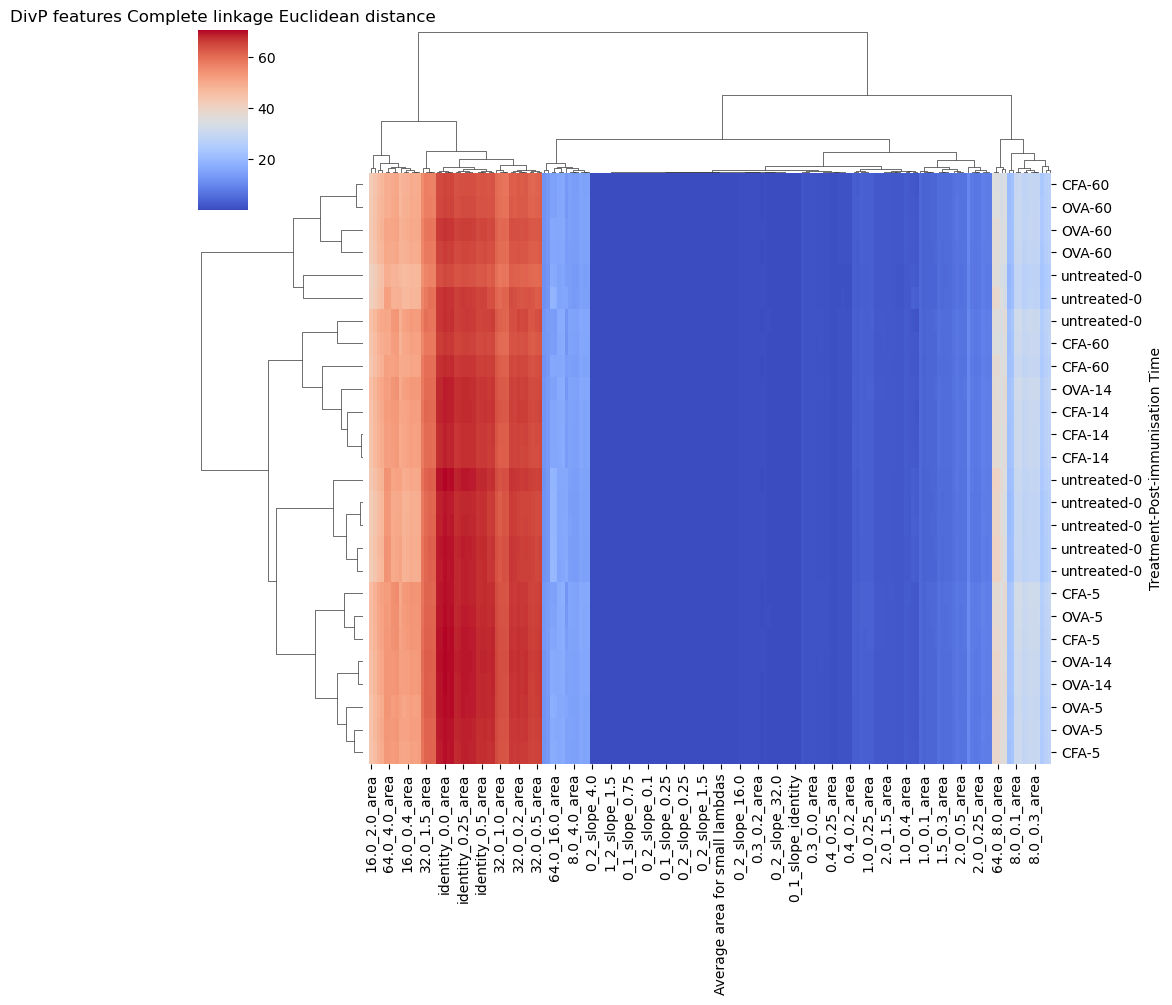

In [151]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_features_HC,
               method='complete',
                metric='euclidean',
              cmap="coolwarm")

if not os.path.isdir(wdir_path+"heatmaps/"):
        os.makedirs(wdir_path+"heatmaps/", exist_ok=False)
    
plt.title("DivP features Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_divP_features.png", bbox_inches='tight')


## Cluster true diversity

In [152]:
divP_qDZ_HC = divP1_all_df.copy()

divP_qDZ_HC = divP_qDZ_HC.set_index(["Treatment", "Post-immunisation Time"])

divP_qDZ_HC = divP_qDZ_HC.drop(["unique_CDR3s", "library", "sample_name", "sample_type"], axis = 1)
divP_qDZ_HC

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3  \
Treatment Post-immunisation Time                                           
untreated 0                       0.061603  0.061597   0.06159  0.061584   
          0                       0.060447  0.060439  0.060432  0.060424   
          0                       0.060274  0.060266  0.060259  0.060251   
          0                       0.060767   0.06076  0.060753  0.060745   
          0                       0.061303  0.061293  0.061284  0.061275   
          0                       0.059625  0.059615  0.059605  0.059595   
          0                       0.059823  0.059814  0.059804  0.059794   
          0                       0.064398   0.06439  0.064381  0.064373   
OVA       5                       0.062555  0.062547  0.062539  0.062531   
          5                        0.06308  0.063073  0.063065  0.063057   
          5                       0.065461  0.065451   0.06544   0.06543   
CFA       5                       0.065079  0.065069  0.065059  0.065048   
          5                       0.062987  0.062978   0.06297  0.062962   
          5                       0.066094  0.066084  0.066073  0.066063   
OVA       14                      0.064739  0.064729  0.064719  0.064709   
          14                      0.063793  0.063785  0.063777  0.063769   
CFA       14                      0.063477  0.063467  0.063458  0.063448   
          14                      0.063479  0.063469  0.063459   0.06345   
          14                      0.063305  0.063297  0.063289  0.063281   
OVA       14                       0.06366  0.063652  0.063643  0.063635   
          60                      0.062027  0.062017  0.062006  0.061996   
CFA       60                      0.063936  0.063925  0.063914  0.063902   
          60                      0.062052  0.062043  0.062034  0.062024   
          60                      0.061544  0.061534  0.061523  0.061512   
OVA       60                      0.062041  0.062029  0.062018  0.062006   
          60                      0.060982  0.060972  0.060962  0.060952   

                                 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6 L_0.1_q_11  \
Treatment Post-immunisation Time                                            
untreated 0                       0.061577  0.061571  0.061564   0.052662   
          0                       0.060417   0.06041  0.060402   0.051631   
          0                       0.060244  0.060236  0.060228   0.050983   
          0                       0.060738  0.060731  0.060723   0.051815   
          0                       0.061266  0.061257  0.061248   0.052154   
          0                       0.059585  0.059575  0.059565   0.050307   
          0                       0.059785  0.059775  0.059766   0.050638   
          0                       0.064364  0.064356  0.064347   0.055997   
OVA       5                       0.062523  0.062516  0.062508    0.05381   
          5                       0.063049  0.063041  0.063033    0.05439   
          5                        0.06542   0.06541    0.0654   0.056469   
CFA       5                       0.065038  0.065028  0.065018   0.055808   
          5                       0.062954  0.062946  0.062938   0.054478   
          5                       0.066053  0.066042  0.066032   0.056947   
OVA       14                      0.064698  0.064688  0.064678   0.055773   
          14                      0.063761  0.063753  0.063745   0.055293   
CFA       14                      0.063439  0.063429   0.06342   0.054632   
          14                       0.06344   0.06343  0.063421   0.053939   
          14                      0.063272  0.063264  0.063256   0.054369   
OVA       14                      0.063627  0.063618   0.06361   0.054869   
          60                      0.061985  0.061975  0.061964   0.053211   
CFA       60                      0.063891   0.06388  0.063869   0.054789   
          60                      0.062015  0.062006  0.

In [153]:
divP_qDZ_HC.isnull().values.any()

False

In [154]:
divP_qDZ_HC = divP_qDZ_HC.apply(pd.to_numeric) 

In [155]:
divP_qDZ_HC.dtypes

L_0.1_q_0          float64
L_0.1_q_1          float64
L_0.1_q_2          float64
L_0.1_q_3          float64
L_0.1_q_4          float64
                    ...   
L_identity_q_3     float64
L_identity_q_4     float64
L_identity_q_5     float64
L_identity_q_6     float64
L_identity_q_11    float64
Length: 128, dtype: object

<Figure size 600x800 with 0 Axes>

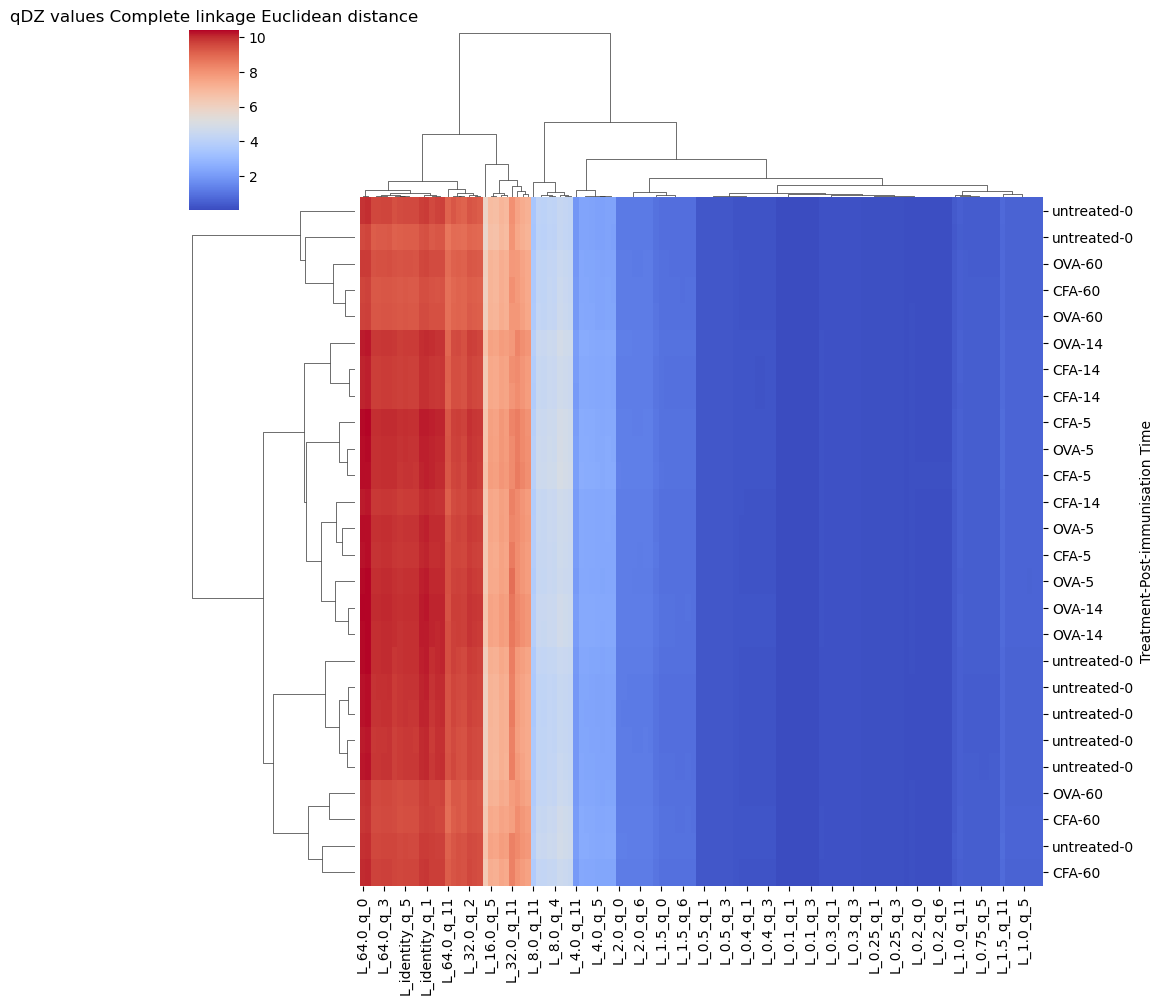

In [156]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_qDZ_HC,
               method='complete',
                metric='euclidean',
                cmap="coolwarm"
                   )

if not os.path.isdir(wdir_path+"heatmaps/"):
        os.makedirs(wdir_path+"heatmaps/", exist_ok=False)
    
plt.title("qDZ values Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_qDZ.png", bbox_inches='tight')
